# EAH stability Paper - sensitivity analyses : Tanner change instead of T2 Tanner stage
### Yashaswini Rajendra Bhat, Kathleen Keller, Pennsylvania State University, Dept of Nutritional Sciences

#### Import required libraries and modules

In [125]:
#import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
%matplotlib inline

In [126]:
pd.set_option('display.max_columns', None)

#### Read in missing value imputed (output of pre-processing)

In [127]:
df=pd.read_excel("EAH_Database_all.xlsx")

In [128]:
df.columns

Index(['id', 'item clean', 'Audio mode', 'v1_date', 'v7_date', 'bmi_screenout',
       'parent_respondent', 'measured_parent', 'risk_status_mom', 'sex',
       ...
       'v1_LMI', 'v7_LMI', 'total_mvpa_avg', 'met_avg', 'percent_mvpa_avg',
       'sedentary_avg', 'percent_sedentary_avg', 'sed_simple_avg',
       'avg_wear_time', 'mvpa_simple_avg'],
      dtype='object', length=103)

In [129]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming your DataFrame is named df and the columns of interest are in outlier_cols
outlier_cols = [
    'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
    'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
    'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
    'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
    'v7_eah_sav_g', 'v1_freddy_pre_eah', 'v7_freddy_pre_eah'
]

# Calculate mean and standard deviation for each column
mean = df[outlier_cols].mean()
std_dev = df[outlier_cols].std()

# Identify outliers that are more than 3 standard deviations from the mean
outliers = (df[outlier_cols] > (mean + 3 * std_dev)) | (df[outlier_cols] < (mean - 3 * std_dev))

# Identify rows with outliers
outliers_df = df[outliers.any(axis=1)]

# Analyze influence using Cook's Distance for a linear model
# Example: Using 'v1_meal_kcal' as the independent variable and 'v1_eah_kcal' as the dependent variable
X = sm.add_constant(df['v1_meal_kcal'])  # independent variable(s)
y = df['v1_eah_kcal']  # dependent variable

model = sm.OLS(y, X).fit()
influence = model.get_influence()
cooks_d, p_values = influence.cooks_distance

# Combine Cook's Distance with outlier identification
outliers_df['cooks_d'] = cooks_d[outliers.any(axis=1)]

# Identify which outliers are highly influential (e.g., Cook's Distance > 4/n, where n is the number of observations)
threshold = 4 / len(df)
high_influence_outliers = outliers_df[outliers_df['cooks_d'] > threshold]

# Display the outliers with high influence
print("High Influence Outliers based on 3SD method and Cook's Distance:")
print(high_influence_outliers)


In [130]:
df['tanner_change']=df['v7_p_pds_imputed']-df['pds_tanner_cat']

### Pre-processing for linear regression

#### Scaling continuous values to fit regression methods next

In [131]:
df_linear_reg=df.copy()

In [132]:
df_linear_reg.columns

Index(['id', 'item clean', 'Audio mode', 'v1_date', 'v7_date', 'bmi_screenout',
       'parent_respondent', 'measured_parent', 'risk_status_mom', 'sex',
       ...
       'v7_LMI', 'total_mvpa_avg', 'met_avg', 'percent_mvpa_avg',
       'sedentary_avg', 'percent_sedentary_avg', 'sed_simple_avg',
       'avg_wear_time', 'mvpa_simple_avg', 'tanner_change'],
      dtype='object', length=104)

In [133]:
scale_cols=['v1_meal_g', 'v1_meal_kcal',
       'v1_eah_g', 'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal',
       'v1_eah_sav_g', 'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal',
       'v7_eah_g', 'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal',
       'v7_eah_sav_kcal', 'v7_eah_sav_g','age_diff','v1_FMI','v7_FMI']

In [134]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the specified columns
scaled_values = scaler.fit_transform(df_linear_reg[scale_cols])

# Replace original columns with scaled values
df_linear_reg[scale_cols] = scaled_values

#### Median split for income and parent_ed

In [135]:
# Recoding the income column
df_linear_reg['income'] = df_linear_reg['income'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

# Recoding the parent_ed column
df_linear_reg['parent_ed'] = df_linear_reg['parent_ed'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

### One-hot encode for pds tanner cat at v1 and v7 

In [136]:
# One-hot encoding for pds_tanner_cat
tanner_change_dummies = pd.get_dummies(df_linear_reg['tanner_change'], prefix='tanner_change', drop_first=True)
df_linear_reg.drop(['tanner_change'], axis=1, inplace=True)
# Add the one-hot encoded columns back to the dataframe
df_linear_reg = pd.concat([df_linear_reg, tanner_change_dummies], axis=1)

In [137]:
df_linear_reg.head()

,id,item clean,Audio mode,v1_date,v7_date,bmi_screenout,parent_respondent,measured_parent,risk_status_mom,sex,age_yr,v7_age_yr,ethnicity,race,income,parent_ed,bmi,v7_bmi,bmi_percentile,v7_bmi_percentile,bmi_z,v7_bmi_z,v1_FMI,v7_FMI,pds_tanner_cat,v7_p_pds_imputed,v1_freddy_pre_meal,v1_freddy_pre_eah,v7_freddy_pre_meal,v7_freddy_pre_eah,v1_meal_g,v1_meal_kcal,v1_eah_g,v1_eah_kcal,v1_eah_sweet_g,v1_eah_sweet_kcal,v1_eah_sav_g,v1_eah_sav_kcal,v7_meal_g,v7_meal_kcal,v7_eah_g,v7_eah_kcal,v7_eah_sweet_g,v7_eah_sweet_kcal,v7_eah_sav_kcal,v7_eah_sav_g,age_diff,v1_vas_popcorn,v1_vas_pretzle,v1_vas_cornchip,v1_vas_cookie,v1_vas_brownie,v1_vas_starburst,v1_vas_skittle,v1_vas_hershey,v1_vas_icecream,v1_vas_pbj_sndwch,v1_vas_ham_sndwch,v1_vas_turkey_sndwch,v1_vas_cheese_sndwch,v1_vas_applesauce,v1_vas_potatoechip,v1_vas_babycarrot,v1_vash_oreo,v1_vas_milk,v1_vas_water,v7_vas_popcorn,v7_vas_pretzle,v7_vas_cornchip,v7_vas_cookie,v7_vas_brownie,v7_vas_starburst,v7_vas_skittle,v7_vas_hershey,v7_vas_icecream,v7_vas_pbj_sndwch,v7_vas_ham_sndwch,v7_vas_turkey_sndwch,v7_vas_cheese_sndwch,v7_vas_applesauce,v7_vas_potatoechip,v7_vas_babycarrot,v7_vas_oreo,v7_vas_milk,v7_vas_water,v1_sandw_sav_g,v1_sandw_sav_kcal,v7_sandw_sav_kcal,v7_sandw_sav_g,v1_consumed_pbj_sndwch_g,v1_consumed_pbj_sndwch_kcal,v7_consumed_pbj_sndwch_g,v7_consumed_pbj_sndwch_kcal,v1_LMI,v7_LMI,total_mvpa_avg,met_avg,percent_mvpa_avg,sedentary_avg,percent_sedentary_avg,sed_simple_avg,avg_wear_time,mvpa_simple_avg,tanner_change_-1,tanner_change_0,tanner_change_1,tanner_change_2
0,1.0,0,H,2018-01-31,2019-07-05,0,0,0,1,0,8.84,10.27,0,0,1,1,16.13,15.96,51.16,33.28,0.03,-0.43,-0.031460,-0.680941,1,1,80,135,44,120,0.057519,0.646737,-0.698086,-0.375482,-0.241090,-0.352173,-0.255413,-0.218743,0.532403,0.313805,-0.925920,-0.630360,-0.478381,-0.598715,-0.096553,-0.216256,-0.181419,4,4,5,5,5,5,5,5,5,5,4,5,4,4,5,3,5,4,5,4,4,5,5,4,4,5,5,5,4,4,4,4,4,5,3,5,4,4,27.67,62.33,269.81,127.23,102.38,353.2110,27.30,94.21,10.90,11.0,419.040000,2.277766,32.330000,675.471182,61.966667,608.388889,1023.666667,354.722222,False,True,False,False
1,2.0,1,H,2018-02-19,2019-05-16,0,0,0,0,0,8.14,9.38,0,0,1,1,16.08,16.05,56.29,44.15,0.16,-0.15,-0.097756,-0.337885,1,1,19,103,1,114,-1.179076,-1.914699,3.020219,3.818148,0.905793,1.036898,6.987945,7.166417,0.051240,0.144315,0.676387,-0.422506,-0.022982,-0.275002,-0.559323,-0.627535,-0.654145,5,5,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5,3,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5,5,4,5,4,5,0.00,0.00,336.05,151.75,0.00,0.0000,2.25,7.76,10.60,10.6,485.007246,2.282391,35.395000,824.239130,58.561667,812.777778,1380.000000,484.027778,False,True,False,False
2,3.0,0,H,2018-02-15,2019-09-11,0,0,0,0,1,8.33,9.90,0,0,1,1,14.52,15.26,18.83,21.87,-0.88,-0.78,-0.495532,-0.761230,1,1,37,86,19,120,-0.678230,-0.617605,-0.299627,-0.149110,-0.084803,-0.256359,0.123767,0.136264,0.308475,0.020000,1.002981,0.553547,0.614682,0.680275,-0.467340,-0.545009,0.166906,5,4,4,4,5,4,5,5,5,2,3,3,2,4,4,3,5,3,4,5,4,4,5,5,3,4,5,5,3,4,4,4,4,5,4,5,5,4,35.42,78.58,324.16,150.91,1.84,6.3480,0.88,3.04,9.84,10.7,473.974347,2.238248,34.387143,830.879942,59.391429,824.261905,1383.857143,473.333333,False,True,False,False
3,5.0,0,H,2018-04-23,2019-08-15,0,0,0,0,1,8.32,9.63,0,0,1,1,15.50,15.68,40.25,31.99,-0.25,-0.47,-0.849111,-0.783127,1,2,20,79,53,79,0.581228,0.303579,-0.591491,-0.728305,-0.285981,-0.740085,-0.305476,-0.272232,0.222940,-0.867615,-0.397403,-1.050573,-0.528634,-0.937128,-0.428318,-0.496305,-0.479983,4,4,4,4,4,3,3,4,4,4,3,3,3,4,3,4,2,4,3,4,4,3,3,3,4,4,4,4,4,3,3,3,4,4,4,3,5,5,15.31,39.99,10.73,4.51,101.72,350.9340,70.84,244.47,11.00,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False
4,6.0,0,H,2018-05-09,2019-06-21,0,0,0,1,1,8.51,9.62,0,0,1,1,17.21,17.01,70.14,56.74,0.53,0.17,1.404954,0.494207,2,3,11,109,61,131,-1.499268,-1.073611,-0.734618,-0.231355,-0.299282,-0.125809,-0.371300,-0.339150,-2.187460,-2.376690,-0.887664,-0.079726,-0.473174,-0.163511,0.371233,0.247786,-0.977590,3,5,5,4,5,5,5,5,5,4,4,5,5,5,5,3,5,2,4,3,4,

In [138]:
df_linear_reg.columns

Index(['id', 'item clean', 'Audio mode', 'v1_date', 'v7_date', 'bmi_screenout',
       'parent_respondent', 'measured_parent', 'risk_status_mom', 'sex',
       ...
       'percent_mvpa_avg', 'sedentary_avg', 'percent_sedentary_avg',
       'sed_simple_avg', 'avg_wear_time', 'mvpa_simple_avg',
       'tanner_change_-1', 'tanner_change_0', 'tanner_change_1',
       'tanner_change_2'],
      dtype='object', length=107)

In [139]:
# Assuming 'bool_col1' and 'bool_col2' are your boolean columns
df_linear_reg['tanner_change_0'] =df_linear_reg['tanner_change_0'].astype(int)
df_linear_reg['tanner_change_1'] = df_linear_reg['tanner_change_1'].astype(int)
df_linear_reg['tanner_change_2'] =df_linear_reg['tanner_change_2'].astype(int)

In [140]:
# Map 'H' to 0 and 'AB' to 1 in the 'audio' column
df_linear_reg['Audio mode'] = df_linear_reg['Audio mode'].map({'H': 0, 'AB': 1})

## Regression Models: Intake (kcal) at visit 1 vs. FMI (adiposity) at follow-up

### Model : EAH (kcal) at baseline (V1) vs V7 FMI 
##### covariates baseline FMI, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff,main predictor: baseline meal intake (kcal)

In [141]:
# Select specific columns as predictors (X) and response (y)
X_mealkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom', 'income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2','age_diff','v1_meal_kcal']]
y_mealkcalFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_mealkcalFMI = sm.add_constant(X_mealkcalFMI)

# Fit a linear regression model using ols
mod_mealkcalFMI = sm.OLS(y_mealkcalFMI, X_mealkcalFMI).fit()

# Get summary of the regression model
print(mod_mealkcalFMI.summary())


                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     30.91
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           3.24e-20
Time:                        13:29:16   Log-Likelihood:                -37.262
No. Observations:                  72   AIC:                             96.52
Df Residuals:                      61   BIC:                             121.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5225      0.278     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.540862715692637
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


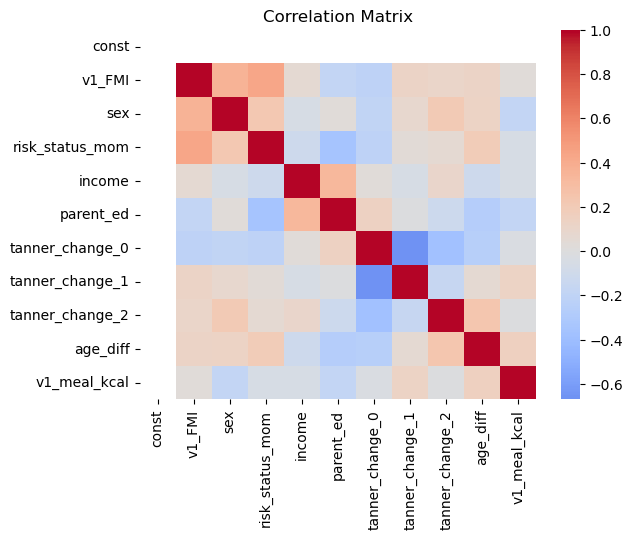

           Variable        VIF
0             const  28.568828
1            v1_FMI   1.427923
2               sex   1.322629
3   risk_status_mom   1.465829
4            income   1.202709
5         parent_ed   1.430092
6   tanner_change_0   3.650162
7   tanner_change_1   3.117973
8   tanner_change_2   2.009694
9          age_diff   1.199841
10     v1_meal_kcal   1.156304
CHECKING FOR HETEROSKEDASTICITY


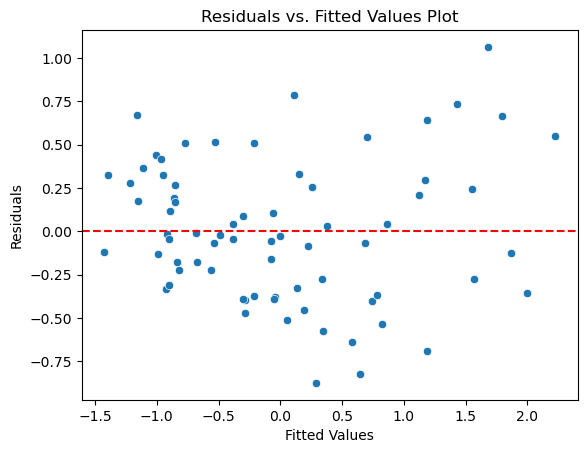

Breusch-Pagan test statistic: 16.73916039220051, p-value: 0.08033865633360628
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


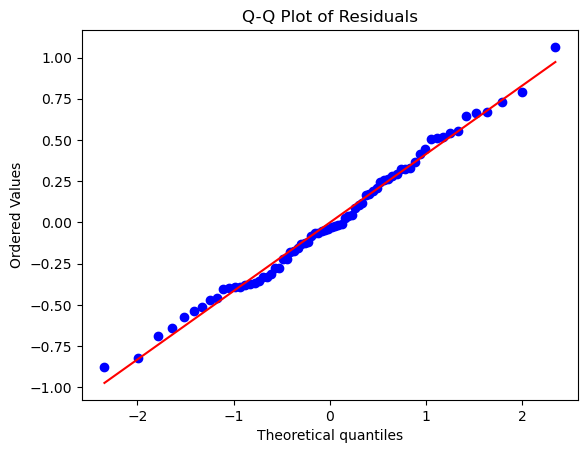

Shapiro-Wilk Test Results:
Statistic: 0.989948034286499
p-value: 0.8403382301330566
Residuals are normally distributed (fail to reject null hypothesis)


In [142]:
# checking for model assumptions
# Calculate the residuals
residuals_mealkcalFMI= mod_mealkcalFMI.resid
# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealkcalFMI = durbin_watson(residuals_mealkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_mealkcalFMI)
if 0 < dw_statistic_mealkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealkcalFMI.values, i) for i in range(X_mealkcalFMI.shape[1])]
print(vif_data)

# 5. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealkcalFMI.fittedvalues, y=residuals_mealkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals_mealkcalFMI, mod_mealkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealkcalFMI, p_value_mealkcalFMI = shapiro(residuals_mealkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealkcalFMI)
print("p-value:", p_value_mealkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH (kcal) at baseline (V1) vs V7 FMI
#### covariates baseline FMI, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff, main predictor: baseline EAH intake (kcal)

In [143]:
# Select specific columns as predictors (X) and response (y)

X_EAHkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2','age_diff','v1_eah_kcal']]
y_EAHkcalFMI = df_linear_reg['v7_FMI']


# Add a constant term to the predictors (intercept)
X_EAHkcalFMI = sm.add_constant(X_EAHkcalFMI)

# Fit a linear regression model using ols
mod_EAHkcalFMI = sm.OLS(y_EAHkcalFMI, X_EAHkcalFMI).fit()

# Get summary of the regression model
print(mod_EAHkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     33.85
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           3.31e-21
Time:                        13:29:17   Log-Likelihood:                -34.504
No. Observations:                  72   AIC:                             91.01
Df Residuals:                      61   BIC:                             116.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5905      0.269     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.486483830064723
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


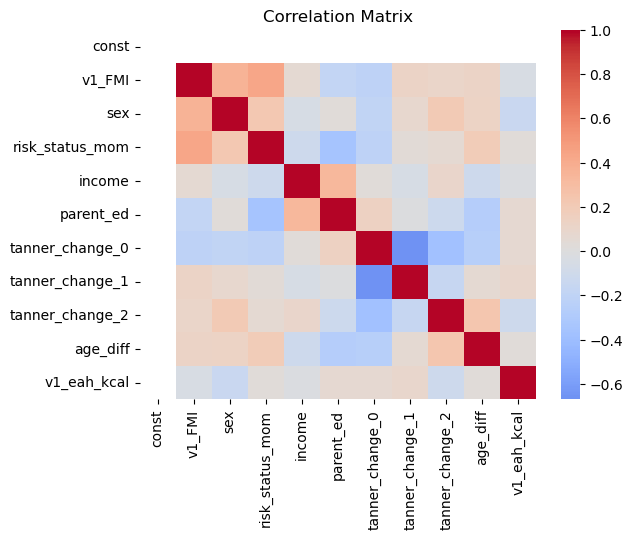

           Variable        VIF
0             const  28.938775
1            v1_FMI   1.416139
2               sex   1.303976
3   risk_status_mom   1.473757
4            income   1.205651
5         parent_ed   1.416230
6   tanner_change_0   3.672664
7   tanner_change_1   3.103850
8   tanner_change_2   2.000905
9          age_diff   1.183109
10      v1_eah_kcal   1.087228
CHECKING FOR HETEROSKEDASTICITY


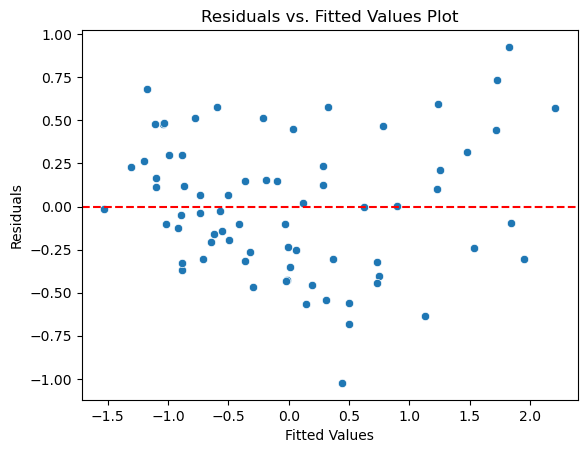

Breusch-Pagan test statistic: 13.967988209805824, p-value: 0.17445677918151323
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


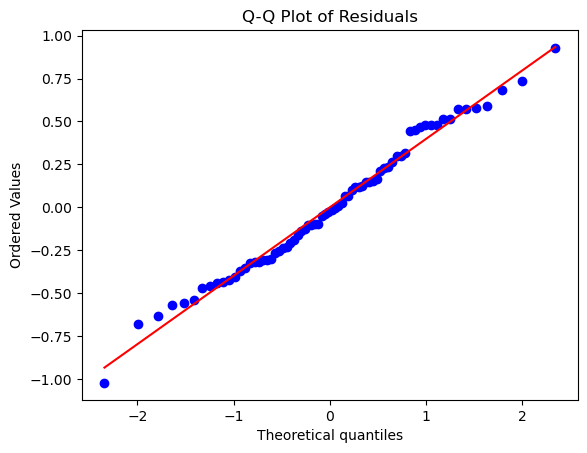

Shapiro-Wilk Test Results:
Statistic: 0.9874587655067444
p-value: 0.6963540315628052
Residuals are normally distributed (fail to reject null hypothesis)


In [144]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHkcalFMI = mod_EAHkcalFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHkcalFMI = durbin_watson(residuals_EAHkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHkcalFMI)
if 0 < dw_statistic_EAHkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHkcalFMI.values, i) for i in range(X_EAHkcalFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHkcalFMI.fittedvalues, y=residuals_EAHkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHkcalFMI, mod_EAHkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")
    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHkcalFMI, p_value_EAHkcalFMI = shapiro(residuals_EAHkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHkcalFMI)
print("p-value:", p_value_EAHkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH Sweet (kcal) at baseline (V1) vs V7 FMI
#### covariates baseline FMI, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff,main predictor: baseline EAH Sweet intake (kcal)

In [145]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2','age_diff', 'v1_eah_sweet_kcal']]
y_EAHsweetkcalFMI = df_linear_reg['v7_FMI']
# Add a constant term to the predictors (intercept)
X_EAHsweetkcalFMI = sm.add_constant(X_EAHsweetkcalFMI)

# Fit a linear regression model using ols
mod_EAHsweetkcalFMI = sm.OLS(y_EAHsweetkcalFMI, X_EAHsweetkcalFMI).fit()

# Get summary of the regression model
print(mod_EAHsweetkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     34.60
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           1.91e-21
Time:                        13:29:18   Log-Likelihood:                -33.838
No. Observations:                  72   AIC:                             89.68
Df Residuals:                      61   BIC:                             114.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6285      0.26

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5243437770949375
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


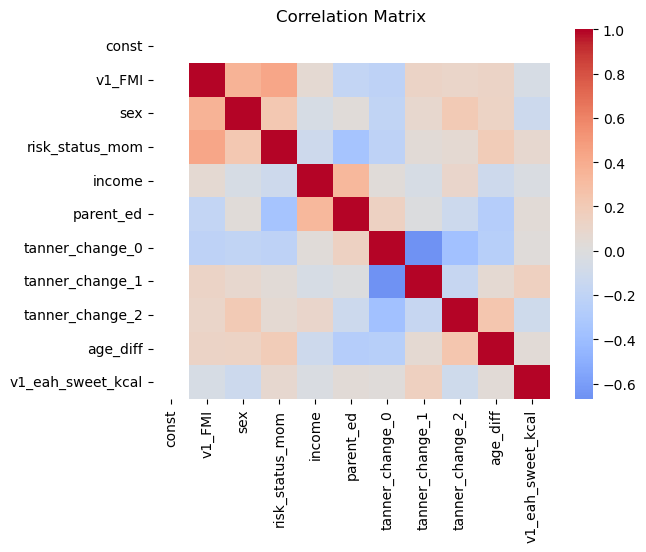

             Variable        VIF
0               const  29.313665
1              v1_FMI   1.421720
2                 sex   1.291842
3     risk_status_mom   1.503696
4              income   1.203771
5           parent_ed   1.407604
6     tanner_change_0   3.714833
7     tanner_change_1   3.194735
8     tanner_change_2   2.008332
9            age_diff   1.181633
10  v1_eah_sweet_kcal   1.116642
CHECKING FOR HETEROSKEDASTICITY


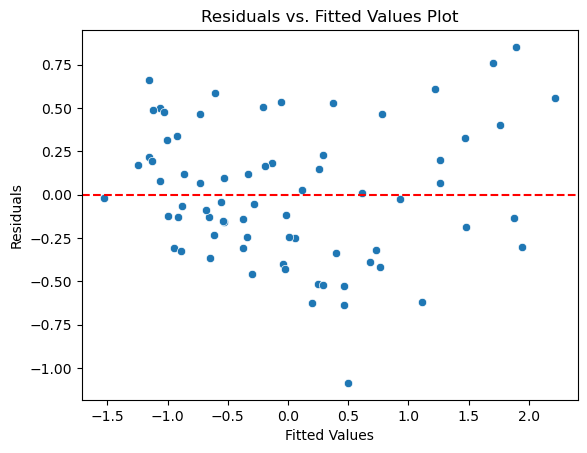

Breusch-Pagan test statistic: 12.926211842887868, p-value: 0.22782671420009049
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


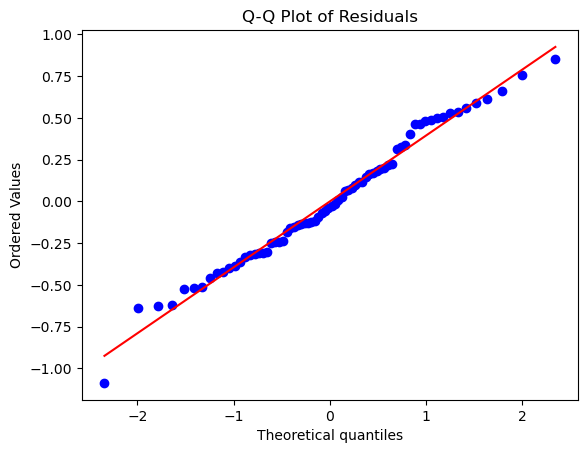

Shapiro-Wilk Test Results:
Statistic: 0.9854382276535034
p-value: 0.5747869610786438
Residuals are normally distributed (fail to reject null hypothesis)


In [146]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsweetkcalFMI = mod_EAHsweetkcalFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetkcalFMI = durbin_watson(residuals_EAHsweetkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetkcalFMI)
if 0 < dw_statistic_EAHsweetkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetkcalFMI.values, i) for i in range(X_EAHsweetkcalFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetkcalFMI.fittedvalues, y=residuals_EAHsweetkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetkcalFMI,  mod_EAHsweetkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetkcalFMI, p_value_EAHsweetkcalFMI = shapiro(residuals_EAHsweetkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetkcalFMI)
print("p-value:", p_value_EAHsweetkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH savory (kcal) at baseline (V1) vs V7 FMI
#### covariates baseline FMI, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff,main predictor: baseline EAH savory intake (kcal)

In [147]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2','age_diff','v1_eah_sav_kcal']]
y_EAHsavkcalFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHsavkcalFMI = sm.add_constant(X_EAHsavkcalFMI)

# Fit a linear regression model using ols
mod_EAHsavkcalFMI = sm.OLS(y_EAHsavkcalFMI, X_EAHsavkcalFMI).fit()

# Get summary of the regression model
print(mod_EAHsavkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     30.90
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           3.25e-20
Time:                        13:29:19   Log-Likelihood:                -37.264
No. Observations:                  72   AIC:                             96.53
Df Residuals:                      61   BIC:                             121.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5142      0.278     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5412541014382544
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


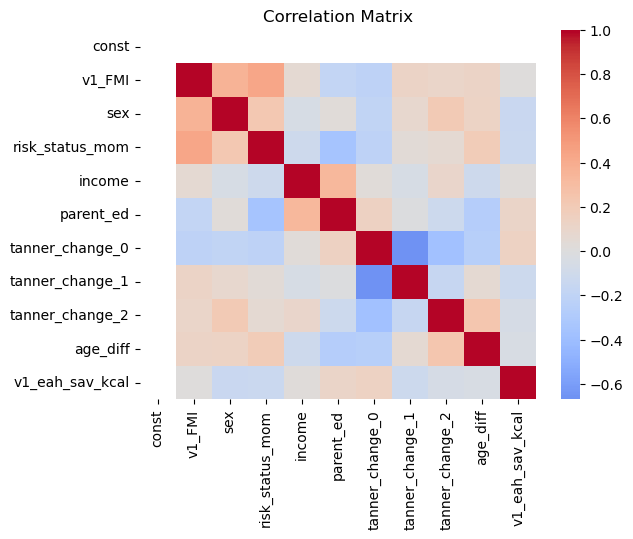

           Variable        VIF
0             const  28.607666
1            v1_FMI   1.448915
2               sex   1.300417
3   risk_status_mom   1.473838
4            income   1.206464
5         parent_ed   1.413568
6   tanner_change_0   3.579021
7   tanner_change_1   3.022527
8   tanner_change_2   1.995664
9          age_diff   1.174747
10  v1_eah_sav_kcal   1.081893
CHECKING FOR HETEROSKEDASTICITY


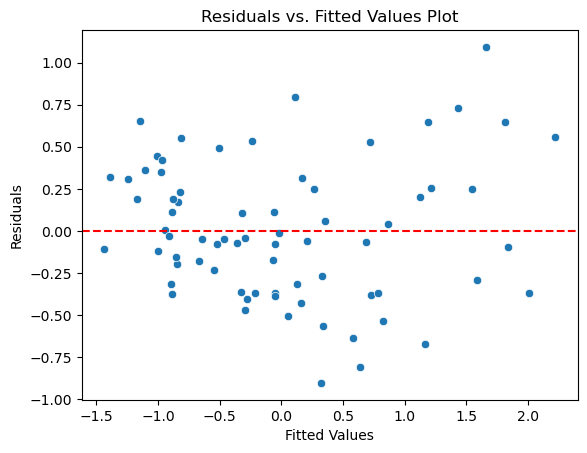

Breusch-Pagan test statistic: 16.094063432227077, p-value: 0.09697120142915137
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


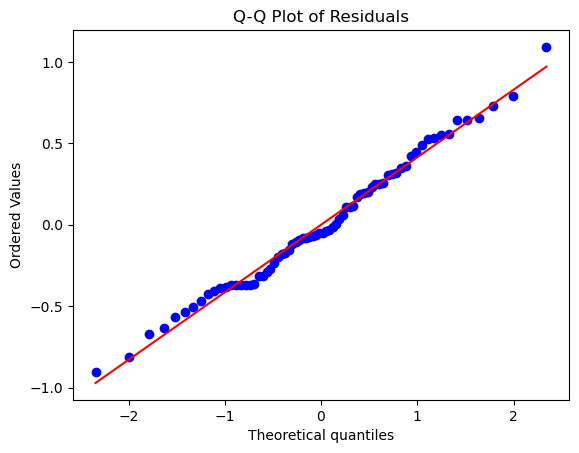

Shapiro-Wilk Test Results:
Statistic: 0.9889887571334839
p-value: 0.7873668074607849
Residuals are normally distributed (fail to reject null hypothesis)


In [148]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavkcalFMI = mod_EAHsavkcalFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavkcalFMI = durbin_watson(residuals_EAHsavkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavkcalFMI)
if 0 < dw_statistic_EAHsavkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavkcalFMI.values, i) for i in range(X_EAHsavkcalFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavkcalFMI.fittedvalues, y=residuals_EAHsavkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsavkcalFMI,  mod_EAHsavkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavkcalFMI, p_value_EAHsavkcalFMI = shapiro(residuals_EAHsavkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavkcalFMI)
print("p-value:", p_value_EAHsavkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsavkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Regression models : Baseline intake (kcal) vs follow-up weight status (BMIz)

### Model : Meal (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates : baseline BMIz, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff, main predictor: baseline meal intake (kcal)

In [149]:
# Select specific columns as predictors (X) and response (y)
X_mealkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2','age_diff', 'v1_meal_kcal']]
y_mealkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_mealkcalBMIz = sm.add_constant(X_mealkcalBMIz)

# Fit a linear regression model using ols
mod_mealkcalBMIz = sm.OLS(y_mealkcalBMIz, X_mealkcalBMIz).fit()

# Get summary of the regression model
print(mod_mealkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     36.55
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           4.71e-22
Time:                        13:29:20   Log-Likelihood:                -18.261
No. Observations:                  72   AIC:                             58.52
Df Residuals:                      61   BIC:                             83.57
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6513      0.217     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9464133340440861
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


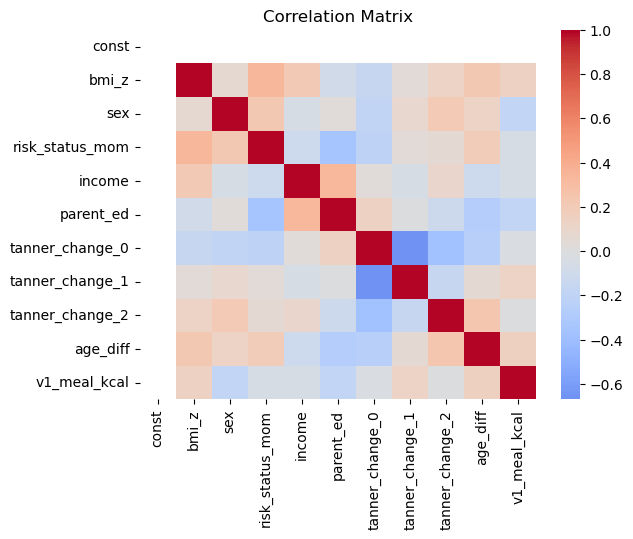

           Variable        VIF
0             const  29.603559
1             bmi_z   1.308002
2               sex   1.187583
3   risk_status_mom   1.459065
4            income   1.262235
5         parent_ed   1.414149
6   tanner_change_0   3.649217
7   tanner_change_1   3.114914
8   tanner_change_2   2.010822
9          age_diff   1.228791
10     v1_meal_kcal   1.175293
CHECKING FOR HETEROSKEDASTICITY


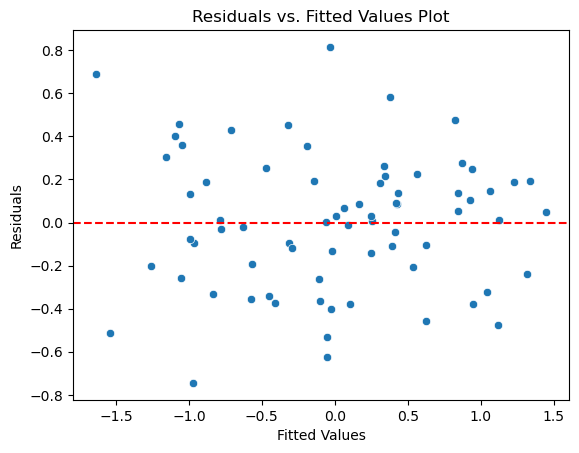

Breusch-Pagan test statistic: 14.889341390484805, p-value: 0.13614865617922137
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


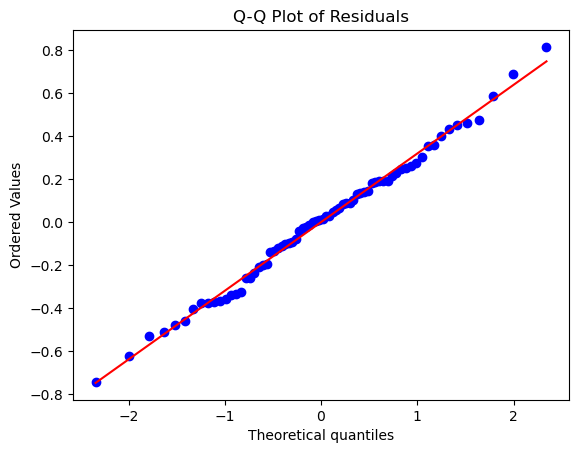

Shapiro-Wilk Test Results:
Statistic: 0.9941457509994507
p-value: 0.9851221442222595
Residuals are normally distributed (fail to reject null hypothesis)


In [150]:
# checking for model assumptions
# Calculate the residuals
residuals_mealkcalBMIz= mod_mealkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealkcalBMIz = durbin_watson(residuals_mealkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_mealkcalBMIz)
if 0 < dw_statistic_mealkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealkcalBMIz.values, i) for i in range(X_mealkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealkcalBMIz.fittedvalues, y=residuals_mealkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_mealkcalBMIz,  mod_mealkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealkcalBMIz, p_value_mealkcalBMIz = shapiro(residuals_mealkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealkcalBMIz)
print("p-value:", p_value_mealkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates :  baseline BMIz, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff, main predictor: baseline EAH intake (kcal)

In [151]:
# Select specific columns as predictors (X) and response (y)
X_EAHkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2','age_diff', 'v1_eah_kcal']]
y_EAHkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHkcalBMIz = sm.add_constant(X_EAHkcalBMIz)

# Fit a linear regression model using ols
mod_EAHkcalBMIz = sm.OLS(y_EAHkcalBMIz, X_EAHkcalBMIz).fit()

# Get summary of the regression model
print(mod_EAHkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     36.75
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           4.10e-22
Time:                        13:29:21   Log-Likelihood:                -18.093
No. Observations:                  72   AIC:                             58.19
Df Residuals:                      61   BIC:                             83.23
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6812      0.217     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.8607049926615529
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


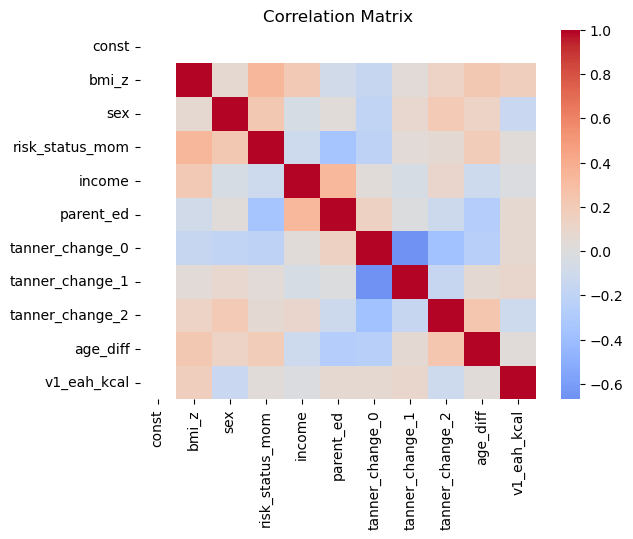

           Variable        VIF
0             const  29.648349
1             bmi_z   1.325377
2               sex   1.182688
3   risk_status_mom   1.446746
4            income   1.273718
5         parent_ed   1.396092
6   tanner_change_0   3.676143
7   tanner_change_1   3.096715
8   tanner_change_2   2.002667
9          age_diff   1.214943
10      v1_eah_kcal   1.129080
CHECKING FOR HETEROSKEDASTICITY


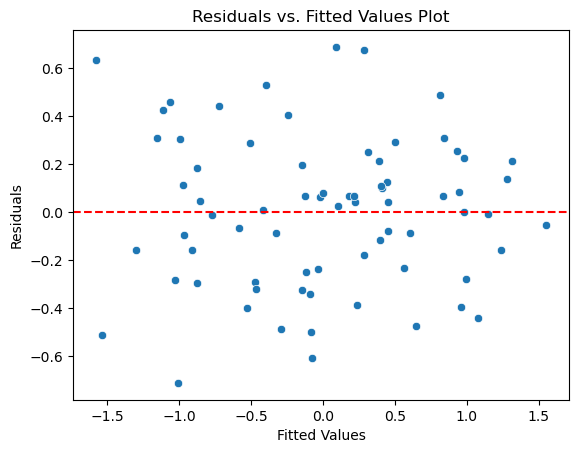

Breusch-Pagan test statistic: 14.608624303919083, p-value: 0.1469955001522476
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


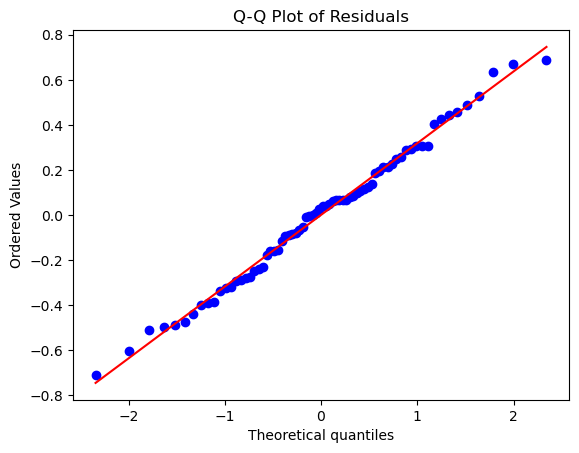

Shapiro-Wilk Test Results:
Statistic: 0.9899956583976746
p-value: 0.8428399562835693
Residuals are normally distributed (fail to reject null hypothesis)


In [152]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHkcalBMIz = mod_EAHkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHkcalBMIz = durbin_watson(residuals_EAHkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHkcalBMIz)
if 0 < dw_statistic_EAHkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHkcalBMIz.values, i) for i in range(X_EAHkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHkcalBMIz.fittedvalues, y=residuals_EAHkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHkcalBMIz,  mod_EAHkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")


# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHkcalBMIz, p_value_EAHkcalBMIz = shapiro(residuals_EAHkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHkcalBMIz)
print("p-value:", p_value_EAHkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH sweet (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates : baseline BMIz, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff,main predictor: baseline EAH sweet intake (kcal)

In [153]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2','age_diff','v1_eah_sweet_kcal']]
y_EAHsweetkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsweetkcalBMIz = sm.add_constant(X_EAHsweetkcalBMIz)

# Fit a linear regression model using ols
mod_EAHsweetkcalBMIz= sm.OLS(y_EAHsweetkcalBMIz, X_EAHsweetkcalBMIz).fit()

# Get summary of the regression model
print(mod_EAHsweetkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     37.78
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           2.02e-22
Time:                        13:29:22   Log-Likelihood:                -17.240
No. Observations:                  72   AIC:                             56.48
Df Residuals:                      61   BIC:                             81.52
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7036      0.21

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.8314812720697544
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


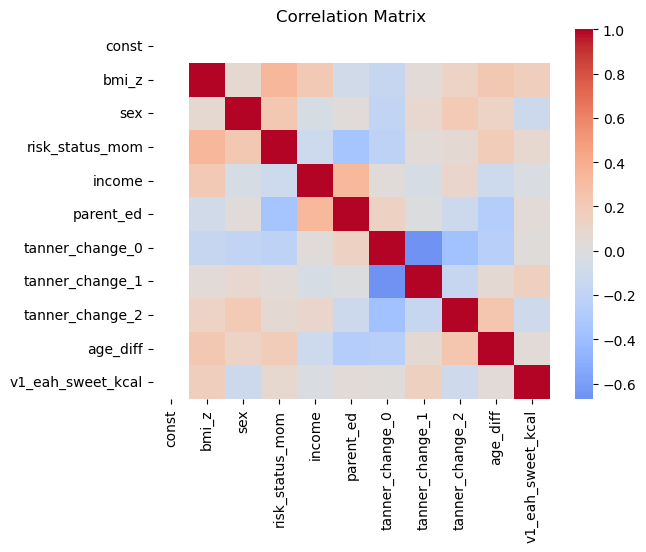

             Variable        VIF
0               const  29.869181
1               bmi_z   1.312415
2                 sex   1.177924
3     risk_status_mom   1.460553
4              income   1.270021
5           parent_ed   1.389078
6     tanner_change_0   3.719763
7     tanner_change_1   3.182462
8     tanner_change_2   2.009832
9            age_diff   1.214553
10  v1_eah_sweet_kcal   1.143779
CHECKING FOR HETEROSKEDASTICITY


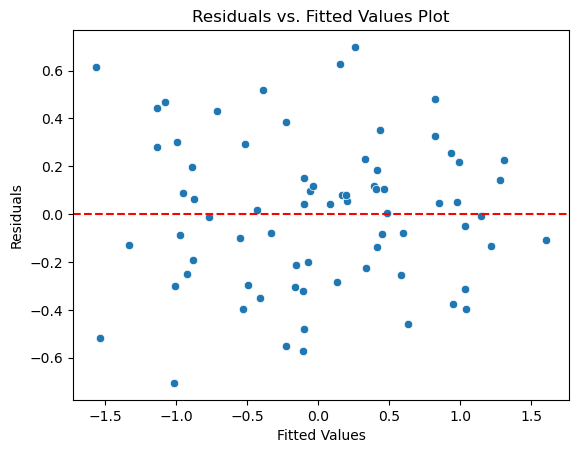

Breusch-Pagan test statistic: 15.137623503198668, p-value: 0.1271243309274198
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


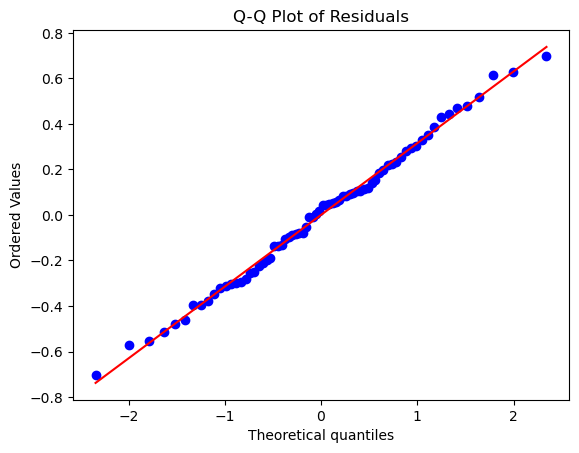

Shapiro-Wilk Test Results:
Statistic: 0.9923741817474365
p-value: 0.9449235200881958
Residuals are normally distributed (fail to reject null hypothesis)


In [154]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsweetkcalBMIz= mod_EAHsweetkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetkcalBMIz = durbin_watson(residuals_EAHsweetkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetkcalBMIz)
if 0 < dw_statistic_EAHsweetkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetkcalBMIz.values, i) for i in range(X_EAHsweetkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetkcalBMIz.fittedvalues, y=residuals_EAHsweetkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetkcalBMIz,  mod_EAHsweetkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetkcalBMIz, p_value_EAHsweetkcalBMIz = shapiro(residuals_EAHsweetkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetkcalBMIz)
print("p-value:", p_value_EAHsweetkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH savory (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates : baseline BMIz, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff, main predictor: baseline EAH savory intake (kcal)

In [155]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2','age_diff', 'v1_eah_sav_kcal']]
y_EAHsavkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsavkcalBMIz = sm.add_constant(X_EAHsavkcalBMIz)

# Fit a linear regression model using ols
mod_EAHsavkcalBMIz= sm.OLS(y_EAHsavkcalBMIz, X_EAHsavkcalBMIz).fit()

# Get summary of the regression model
print(mod_EAHsavkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     36.01
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           6.91e-22
Time:                        13:29:23   Log-Likelihood:                -18.723
No. Observations:                  72   AIC:                             59.45
Df Residuals:                      61   BIC:                             84.49
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6680      0.218     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9055164195693615
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


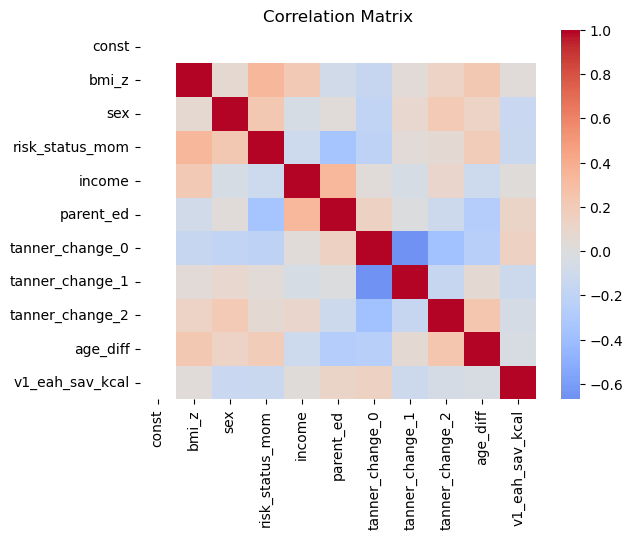

           Variable        VIF
0             const  29.567332
1             bmi_z   1.287861
2               sex   1.163304
3   risk_status_mom   1.455175
4            income   1.264181
5         parent_ed   1.386951
6   tanner_change_0   3.577892
7   tanner_change_1   3.013892
8   tanner_change_2   1.999530
9          age_diff   1.211417
10  v1_eah_sav_kcal   1.067041
CHECKING FOR HETEROSKEDASTICITY


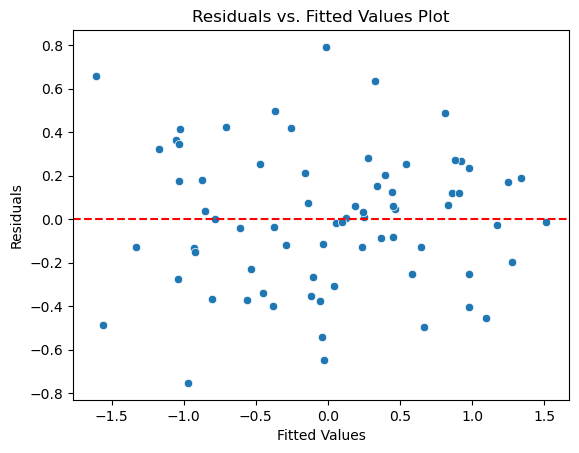

Breusch-Pagan test statistic: 15.312683294027607, p-value: 0.12107101291226463
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


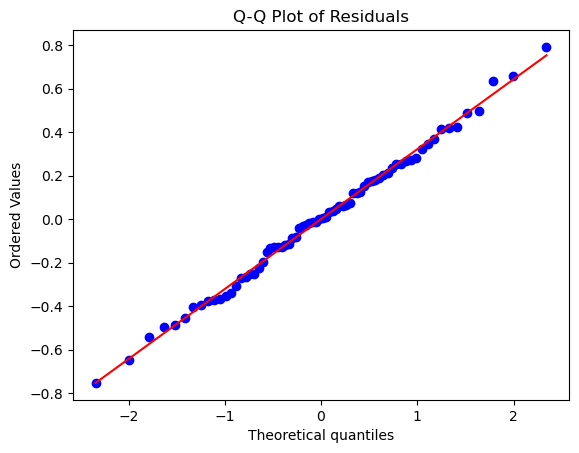

Shapiro-Wilk Test Results:
Statistic: 0.9955915808677673
p-value: 0.9973740577697754
Residuals are normally distributed (fail to reject null hypothesis)


In [156]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavkcalBMIz= mod_EAHsavkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavkcalBMIz = durbin_watson(residuals_EAHsavkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavkcalBMIz)
if 0 < dw_statistic_EAHsavkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavkcalBMIz.values, i) for i in range(X_EAHsavkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavkcalBMIz.fittedvalues, y=residuals_EAHsavkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsavkcalBMIz,  mod_EAHsavkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")
    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavkcalBMIz, p_value_EAHsavkcalBMIz = shapiro(residuals_EAHsavkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavkcalBMIz)
print("p-value:", p_value_EAHsavkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsavkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Regression model: Intake (gram) at baseline V1 vs follow-up adiposity (FMI)

### Model : Meal (gram) at baseline (V1) vs V7 follow-up adiposity FMI
#### covariates : baseline FMI, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff, main predictor: baseline meal intake (gram)

In [157]:
# Select specific columns as predictors (X) and response (y)
X_mealgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2','age_diff', 'v1_meal_g']]
y_mealgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_mealgFMI = sm.add_constant(X_mealgFMI)

# Fit a linear regression model using ols
mod_mealgFMI= sm.OLS(y_mealgFMI, X_mealgFMI).fit()

# Get summary of the regression model
print(mod_mealgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     30.84
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           3.42e-20
Time:                        13:29:24   Log-Likelihood:                -37.326
No. Observations:                  72   AIC:                             96.65
Df Residuals:                      61   BIC:                             121.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5158      0.282     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.554898916166871
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


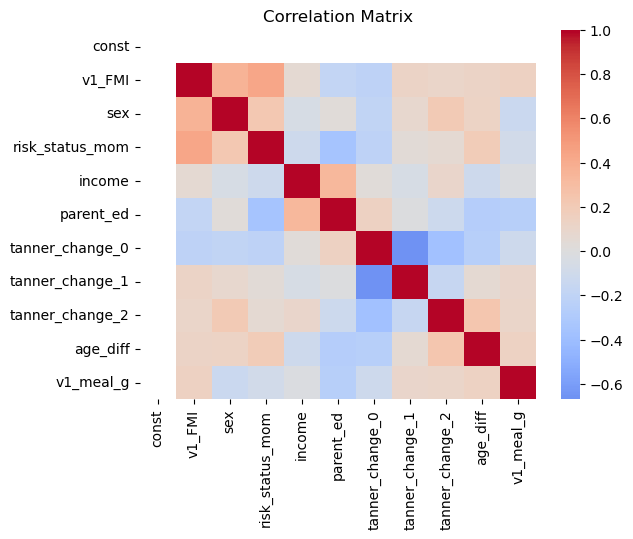

           Variable        VIF
0             const  29.352980
1            v1_FMI   1.491304
2               sex   1.315771
3   risk_status_mom   1.543006
4            income   1.202751
5         parent_ed   1.484962
6   tanner_change_0   3.579585
7   tanner_change_1   3.020301
8   tanner_change_2   2.009676
9          age_diff   1.182074
10        v1_meal_g   1.227770
CHECKING FOR HETEROSKEDASTICITY


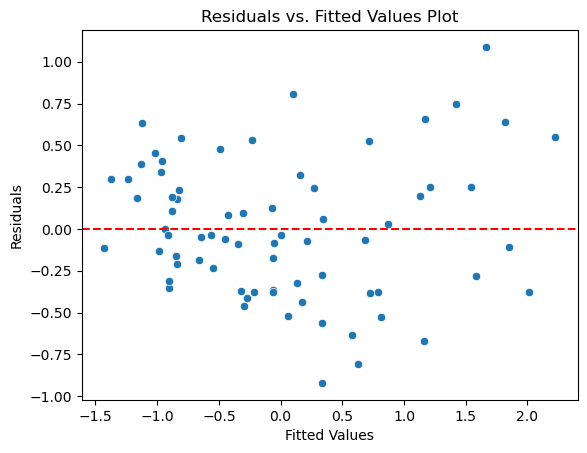

Breusch-Pagan test statistic: 15.977421749329924, p-value: 0.10028055544246384
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


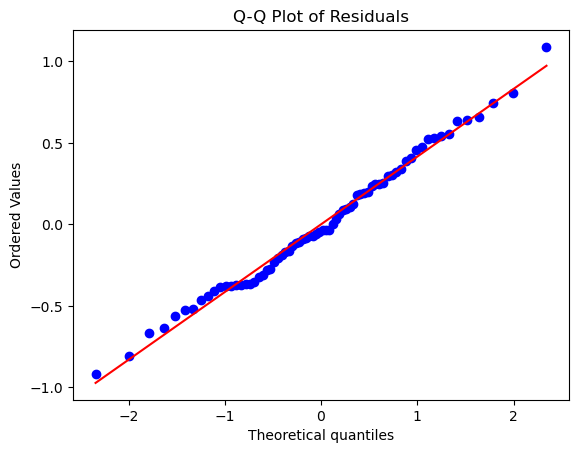

Shapiro-Wilk Test Results:
Statistic: 0.9905267357826233
p-value: 0.8697052597999573
Residuals are normally distributed (fail to reject null hypothesis)


In [158]:
# checking for model assumptions
# Calculate the residuals
residuals_mealgFMI= mod_mealgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealgFMI = durbin_watson(residuals_mealgFMI)
print("Durbin-Watson Statistic:", dw_statistic_mealgFMI)
if 0 < dw_statistic_mealgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealgFMI.values, i) for i in range(X_mealgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealgFMI.fittedvalues, y=residuals_mealgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_mealgFMI,  mod_mealgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealgFMI, p_value_mealgFMI = shapiro(residuals_mealgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealgFMI)
print("p-value:", p_value_mealgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH (gram) at baseline (V1) vs V7 follow-up adiposity FMI (v7)
#### covariates :baseline FMI, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff, main predictor: baseline EAH intake (gram)

In [159]:
# Select specific columns as predictors (X) and response (y)
X_EAHgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2', 'age_diff','v1_eah_g']]
y_EAHgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHgFMI = sm.add_constant(X_EAHgFMI)

# Fit a linear regression model using ols
mod_EAHgFMI= sm.OLS(y_EAHgFMI, X_EAHgFMI).fit()

# Get summary of the regression model
print(mod_EAHgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     30.98
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           3.05e-20
Time:                        13:29:25   Log-Likelihood:                -37.188
No. Observations:                  72   AIC:                             96.38
Df Residuals:                      61   BIC:                             121.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5320      0.279     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5225124357682451
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


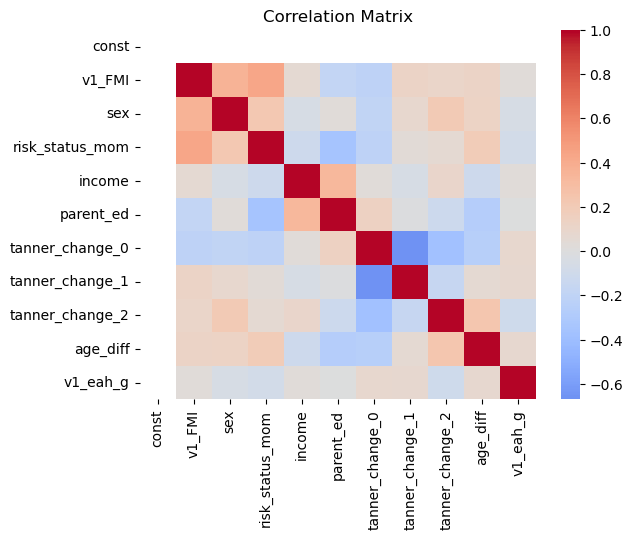

           Variable        VIF
0             const  28.789716
1            v1_FMI   1.423866
2               sex   1.270958
3   risk_status_mom   1.461192
4            income   1.203736
5         parent_ed   1.396920
6   tanner_change_0   3.688662
7   tanner_change_1   3.092699
8   tanner_change_2   1.995028
9          age_diff   1.193736
10         v1_eah_g   1.074261
CHECKING FOR HETEROSKEDASTICITY


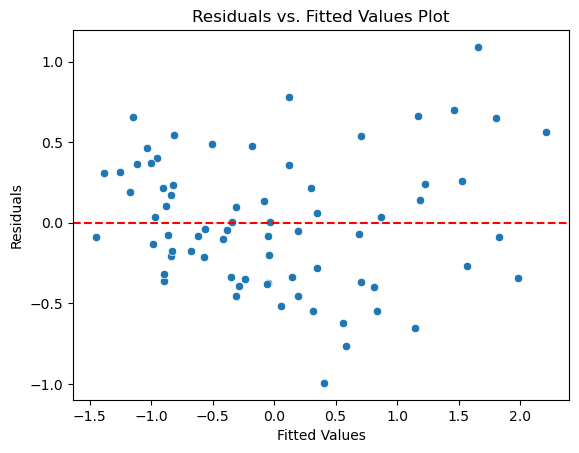

Breusch-Pagan test statistic: 16.094146998851738, p-value: 0.09696886502245347
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


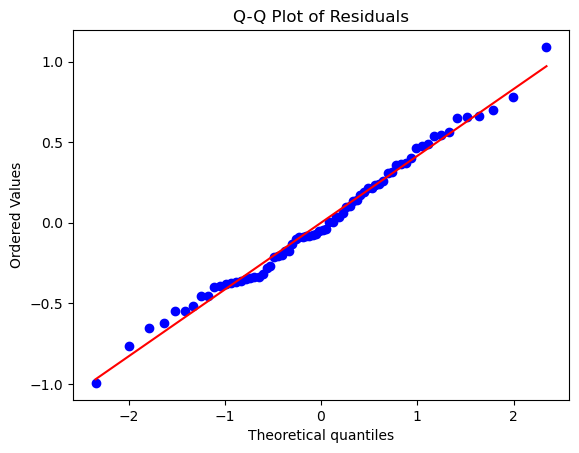

Shapiro-Wilk Test Results:
Statistic: 0.9909747838973999
p-value: 0.8907520771026611
Residuals are normally distributed (fail to reject null hypothesis)


In [160]:
# checking for model assumptions 
# Calculate the residuals
residuals_EAHgFMI= mod_EAHgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHgFMI = durbin_watson(residuals_EAHgFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHgFMI)
if 0 < dw_statistic_EAHgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHgFMI.values, i) for i in range(X_EAHgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHgFMI.fittedvalues, y=residuals_EAHgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHgFMI,  mod_EAHgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")


# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHgFMI, p_value_EAHgFMI = shapiro(residuals_EAHgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHgFMI)
print("p-value:", p_value_EAHgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH sweet (gram) at baseline (V1) vs V7 follow-up adiposity FMI (v7)
#### covariates : baseline FMI, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff,main predictor: baseline EAH sweet intake (gram)

In [161]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff','v1_eah_sweet_g']]
y_EAHsweetgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHsweetgFMI = sm.add_constant(X_EAHsweetgFMI)

# Fit a linear regression model using ols
mod_EAHsweetgFMI= sm.OLS(y_EAHsweetgFMI, X_EAHsweetgFMI).fit()

# Get summary of the regression model
print(mod_EAHsweetgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     35.90
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           7.49e-22
Time:                        13:29:26   Log-Likelihood:                -32.709
No. Observations:                  72   AIC:                             87.42
Df Residuals:                      61   BIC:                             112.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6535      0.265     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.4422603136317047
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


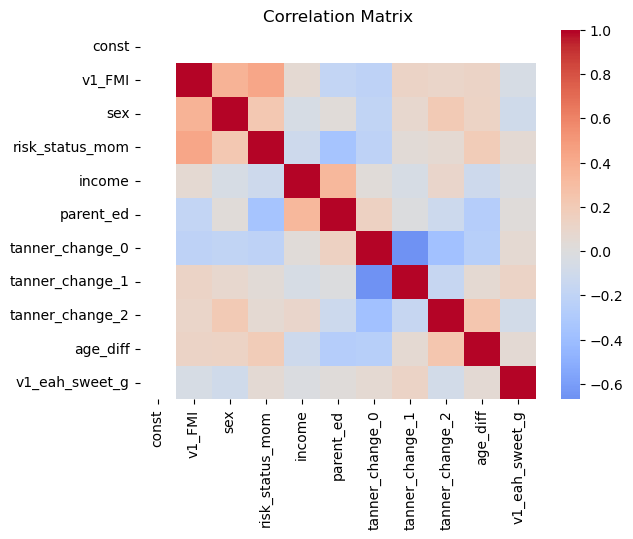

           Variable        VIF
0             const  29.437577
1            v1_FMI   1.419604
2               sex   1.283795
3   risk_status_mom   1.486954
4            income   1.203094
5         parent_ed   1.400604
6   tanner_change_0   3.778449
7   tanner_change_1   3.213882
8   tanner_change_2   2.022209
9          age_diff   1.183620
10   v1_eah_sweet_g   1.103540
CHECKING FOR HETEROSKEDASTICITY


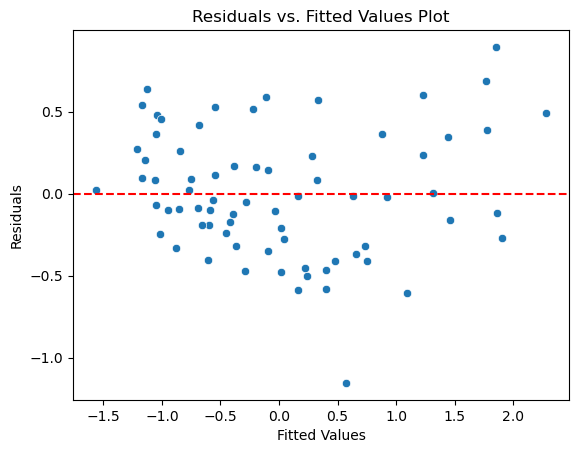

Breusch-Pagan test statistic: 13.391730591112964, p-value: 0.20258670880808544
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


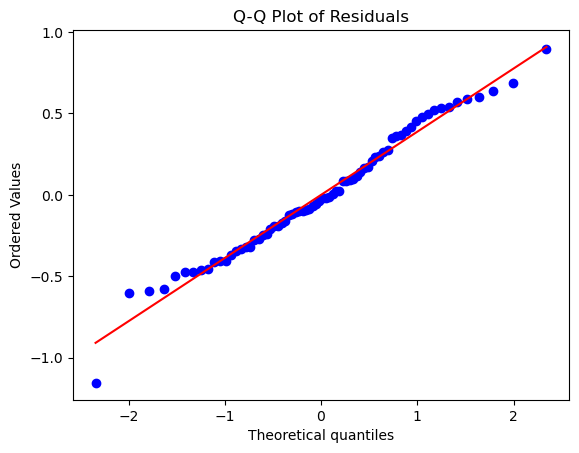

Shapiro-Wilk Test Results:
Statistic: 0.9838846325874329
p-value: 0.48714643716812134
Residuals are normally distributed (fail to reject null hypothesis)


In [162]:
# checking for model assumptions
# Calculate the residuals
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
residuals_EAHsweetgFMI= mod_EAHsweetgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetgFMI = durbin_watson(residuals_EAHsweetgFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetgFMI)
if 0 < dw_statistic_EAHsweetgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetgFMI.values, i) for i in range(X_EAHsweetgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetgFMI.fittedvalues, y=residuals_EAHsweetgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetgFMI,  mod_EAHsweetgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")   
    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetgFMI, p_value_EAHsweetgFMI = shapiro(residuals_EAHsweetgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetgFMI)
print("p-value:", p_value_EAHsweetgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH savory (gram) at baseline (V1) vs V7 follow-up adiposity FMI (v7)
#### covariates : baseline FMI, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff,main predictor: baseline EAH savory intake (gram)

In [163]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1','tanner_change_2','age_diff','v1_eah_sav_g']]
y_EAHsavgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHsavgFMI = sm.add_constant(X_EAHsavgFMI)

# Fit a linear regression model using ols
mod_EAHsavgFMI= sm.OLS(y_EAHsavgFMI, X_EAHsavgFMI).fit()

# Get summary of the regression model
print(mod_EAHsavgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     30.91
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           3.24e-20
Time:                        13:29:26   Log-Likelihood:                -37.260
No. Observations:                  72   AIC:                             96.52
Df Residuals:                      61   BIC:                             121.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5140      0.278     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5413043288822768
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


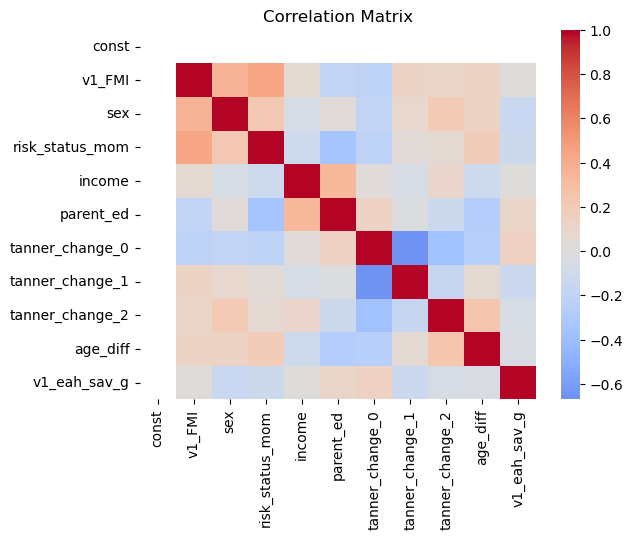

           Variable        VIF
0             const  28.610311
1            v1_FMI   1.451729
2               sex   1.302962
3   risk_status_mom   1.469957
4            income   1.206986
5         parent_ed   1.415217
6   tanner_change_0   3.579034
7   tanner_change_1   3.025904
8   tanner_change_2   1.995117
9          age_diff   1.174789
10     v1_eah_sav_g   1.082347
CHECKING FOR HETEROSKEDASTICITY


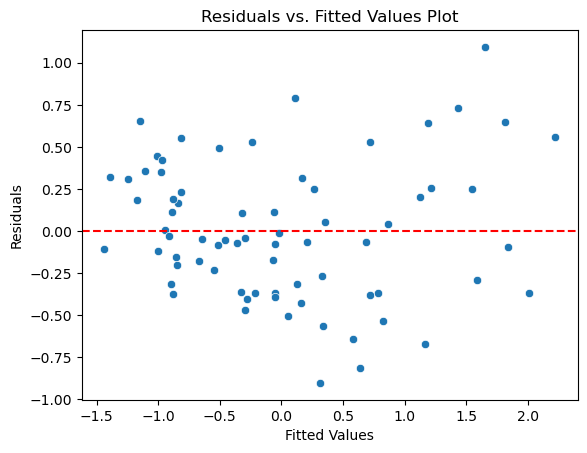

Breusch-Pagan test statistic: 16.084526895743927, p-value: 0.09723815243130546
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


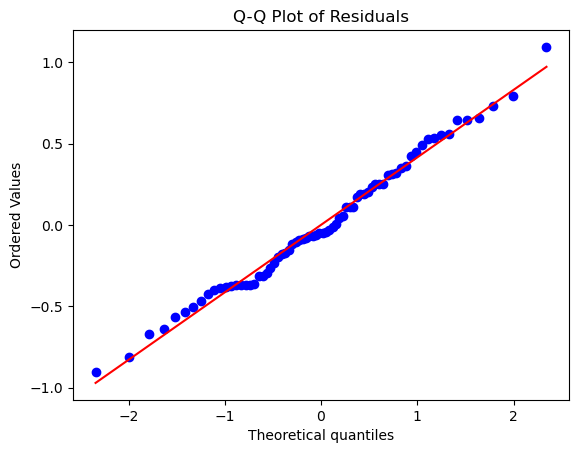

Shapiro-Wilk Test Results:
Statistic: 0.9889719486236572
p-value: 0.7864028215408325
Residuals are normally distributed (fail to reject null hypothesis)


In [164]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavgFMI= mod_EAHsavgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavgFMI = durbin_watson(residuals_EAHsavgFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavgFMI)
if 0 < dw_statistic_EAHsavgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavgFMI.values, i) for i in range(X_EAHsavgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavgFMI.fittedvalues, y=residuals_EAHsavgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsavgFMI,  mod_EAHsavgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavgFMI, p_value_EAHsavgFMI = shapiro(residuals_EAHsavgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavgFMI)
print("p-value:", p_value_EAHsavgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level 
if p_value_EAHsavgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Regression models: Intake (gram) at baseline (v1) vs follow-up (v7) weight status (BMIz)

### Model : Meal (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates : baseline BMIz, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff, main predictor: baseline meal intake (gram)

In [165]:
# Select specific columns as predictors (X) and response (y)
X_mealgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff','v1_meal_g']]
y_mealgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_mealgBMIz= sm.add_constant(X_mealgBMIz)

# Fit a linear regression model using ols
mod_mealgBMIz= sm.OLS(y_mealgBMIz, X_mealgBMIz).fit()

# Get summary of the regression model
print(mod_mealgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     36.95
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           3.58e-22
Time:                        13:29:27   Log-Likelihood:                -17.931
No. Observations:                  72   AIC:                             57.86
Df Residuals:                      61   BIC:                             82.91
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6081      0.221     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.8997303347105763
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


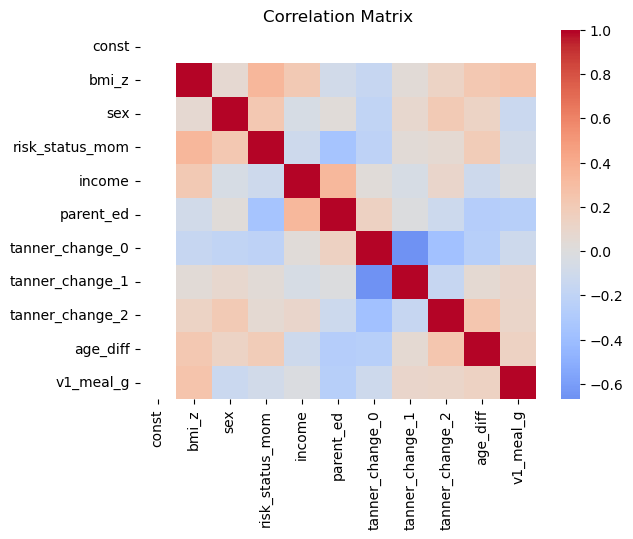

           Variable        VIF
0             const  30.814455
1             bmi_z   1.409973
2               sex   1.165602
3   risk_status_mom   1.553511
4            income   1.261626
5         parent_ed   1.488705
6   tanner_change_0   3.578243
7   tanner_change_1   3.017063
8   tanner_change_2   2.008811
9          age_diff   1.212186
10        v1_meal_g   1.288049
CHECKING FOR HETEROSKEDASTICITY


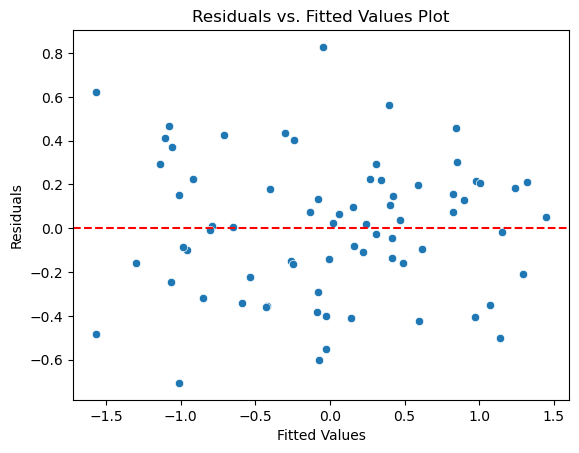

Breusch-Pagan test statistic: 14.716989507403124, p-value: 0.14272561647709595
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


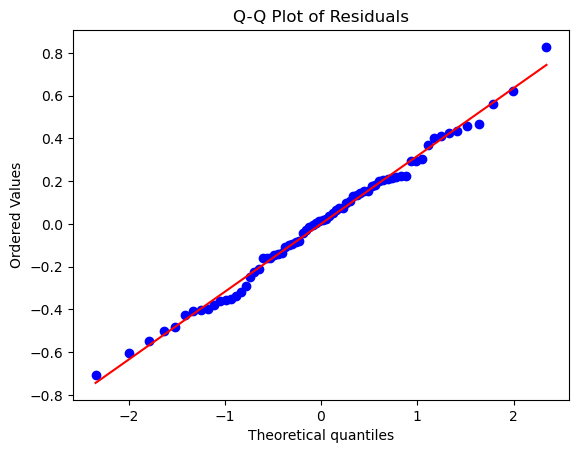

Shapiro-Wilk Test Results:
Statistic: 0.9929166436195374
p-value: 0.9606457948684692
Residuals are normally distributed (fail to reject null hypothesis)


In [166]:
# checking for model assumptions
# Calculate the residuals
residuals_mealgBMIz= mod_mealgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealgBMIz = durbin_watson(residuals_mealgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_mealgBMIz)
if 0 < dw_statistic_mealgBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealgBMIz.values, i) for i in range(X_mealgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealgBMIz.fittedvalues, y=residuals_mealgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_mealgBMIz,  mod_mealgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  
      
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealgBMIz, p_value_mealgBMIz = shapiro(residuals_mealgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealgBMIz)
print("p-value:", p_value_mealgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates : cbaseline BMIz, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff, main predictor: baseline EAH intake (gram)

In [167]:
# Select specific columns as predictors (X) and response (y)
X_EAHgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1','tanner_change_2','age_diff', 'v1_eah_g']]
y_EAHgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHgBMIz= sm.add_constant(X_EAHgBMIz)

# Fit a linear regression model using ols
mod_EAHgBMIz= sm.OLS(y_EAHgBMIz, X_EAHgBMIz).fit()

# Get summary of the regression model
print(mod_EAHgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     37.27
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           2.87e-22
Time:                        13:29:28   Log-Likelihood:                -17.663
No. Observations:                  72   AIC:                             57.33
Df Residuals:                      61   BIC:                             82.37
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6875      0.216     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.8373738867378921
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


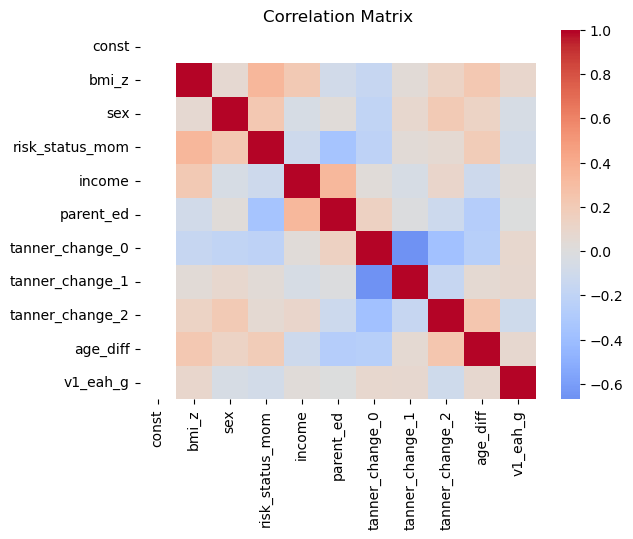

           Variable        VIF
0             const  29.675208
1             bmi_z   1.293609
2               sex   1.148824
3   risk_status_mom   1.451409
4            income   1.260359
5         parent_ed   1.376422
6   tanner_change_0   3.687377
7   tanner_change_1   3.088447
8   tanner_change_2   1.997922
9          age_diff   1.225539
10         v1_eah_g   1.082965
CHECKING FOR HETEROSKEDASTICITY


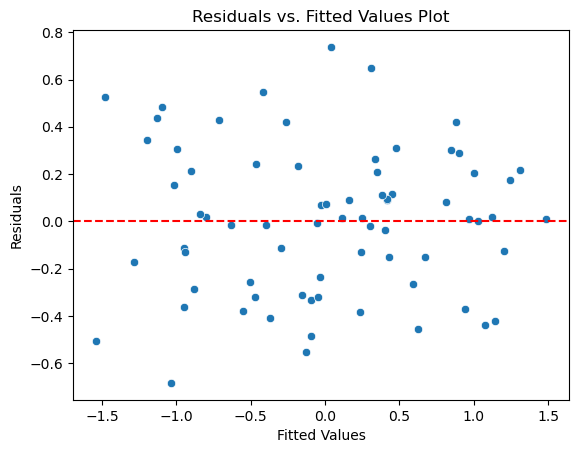

Breusch-Pagan test statistic: 12.117105950828506, p-value: 0.27729550860148106
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


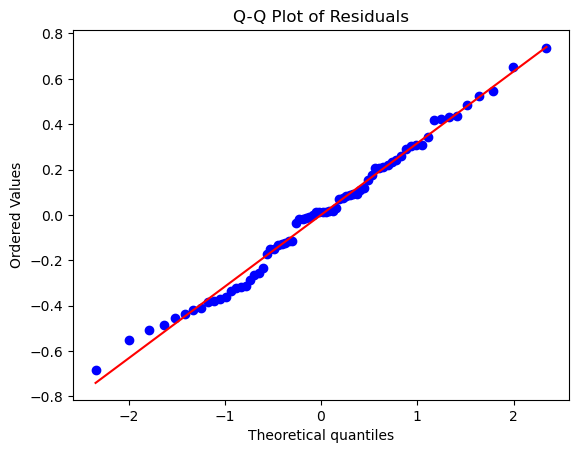

Shapiro-Wilk Test Results:
Statistic: 0.9881817698478699
p-value: 0.7399743795394897
Residuals are normally distributed (fail to reject null hypothesis)


In [168]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHgBMIz= mod_EAHgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHgBMIz = durbin_watson(residuals_EAHgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHgBMIz)
if 0 < dw_statistic_EAHgBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHgBMIz.values, i) for i in range(X_EAHgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHgBMIz.fittedvalues, y=residuals_EAHgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHgBMIz,  mod_EAHgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  
      
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHgBMIz, p_value_EAHgBMIz = shapiro(residuals_EAHgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHgBMIz)
print("p-value:", p_value_EAHgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH sweet (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates : baseline BMIz, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff, main predictor: baseline EAH sweet intake (gram)

In [169]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','tanner_change_0', 'tanner_change_1', 'tanner_change_2','age_diff', 'v1_eah_sweet_g']]
y_EAHsweetgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsweetgBMIz= sm.add_constant(X_EAHsweetgBMIz)

# Fit a linear regression model using ols
mod_EAHsweetgBMIz= sm.OLS(y_EAHsweetgBMIz, X_EAHsweetgBMIz).fit()

# Get summary of the regression model
print(mod_EAHsweetgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     38.72
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           1.07e-22
Time:                        13:29:29   Log-Likelihood:                -16.474
No. Observations:                  72   AIC:                             54.95
Df Residuals:                      61   BIC:                             79.99
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7151      0.213     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.7640619591143758
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


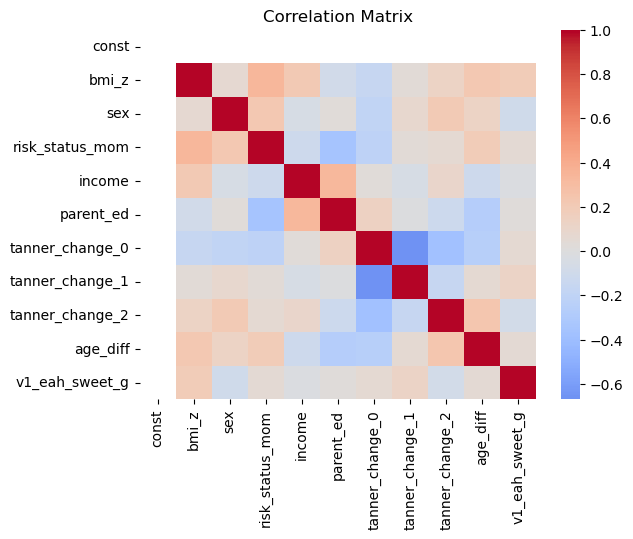

           Variable        VIF
0             const  29.917672
1             bmi_z   1.329675
2               sex   1.167353
3   risk_status_mom   1.449557
4            income   1.269504
5         parent_ed   1.380880
6   tanner_change_0   3.788400
7   tanner_change_1   3.204273
8   tanner_change_2   2.022830
9          age_diff   1.215073
10   v1_eah_sweet_g   1.146931
CHECKING FOR HETEROSKEDASTICITY


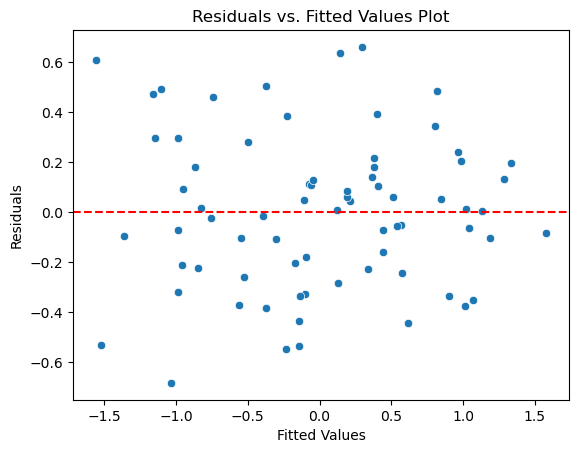

Breusch-Pagan test statistic: 15.602079618202229, p-value: 0.11160405259761674
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


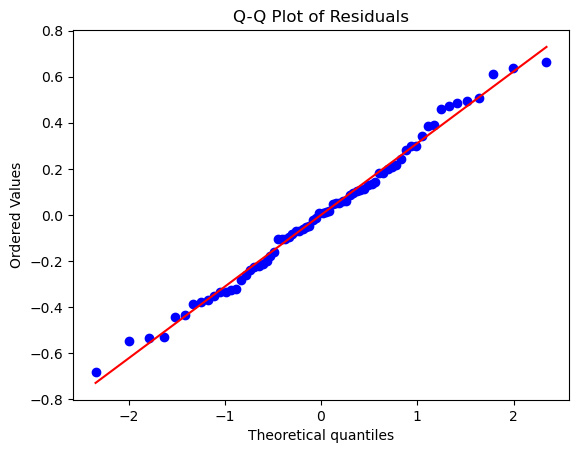

Shapiro-Wilk Test Results:
Statistic: 0.9884606599807739
p-value: 0.7565622329711914
Residuals are normally distributed (fail to reject null hypothesis)


In [170]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsweetgBMIz= mod_EAHsweetgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetgBMIz = durbin_watson(residuals_EAHsweetgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetgBMIz)
if 0 < dw_statistic_EAHsweetgBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetgBMIz.values, i) for i in range(X_EAHsweetgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetgBMIz.fittedvalues, y=residuals_EAHsweetgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetgBMIz,  mod_EAHsweetgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  
      

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetgBMIz, p_value_EAHsweetgBMIz = shapiro(residuals_EAHsweetgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetgBMIz)
print("p-value:", p_value_EAHsweetgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH savory (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates : baseline BMIz, sex, risk status based on maternal weight, tanner stage change v7-v1, parent education, parent yearly income, age-diff, main predictor: baseline EAH savory intake (gram)

In [171]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2', 'age_diff', 'v1_eah_sav_g']]
y_EAHsavgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsavgBMIz= sm.add_constant(X_EAHsavgBMIz)

# Fit a linear regression model using ols
mod_EAHsavgBMIz= sm.OLS(y_EAHsavgBMIz, X_EAHsavgBMIz).fit()

# Get summary of the regression model
print(mod_EAHsavgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     35.97
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           7.10e-22
Time:                        13:29:30   Log-Likelihood:                -18.756
No. Observations:                  72   AIC:                             59.51
Df Residuals:                      61   BIC:                             84.55
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6671      0.219     

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9045086717318136
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


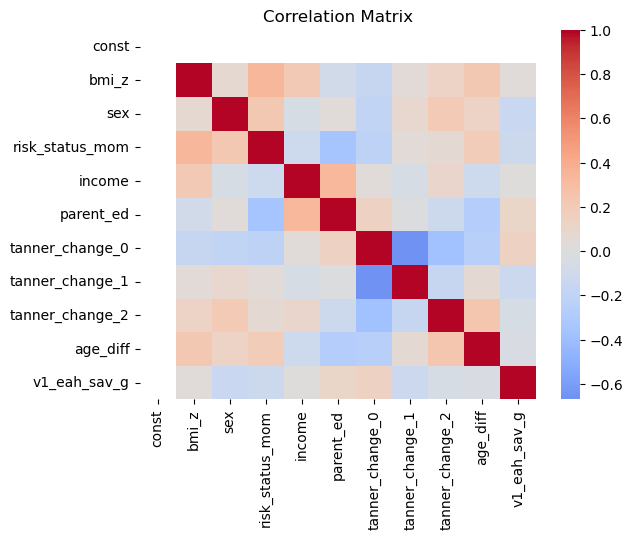

           Variable        VIF
0             const  29.564076
1             bmi_z   1.287012
2               sex   1.164465
3   risk_status_mom   1.451265
4            income   1.264396
5         parent_ed   1.388065
6   tanner_change_0   3.577956
7   tanner_change_1   3.016762
8   tanner_change_2   1.998871
9          age_diff   1.211456
10     v1_eah_sav_g   1.064717
CHECKING FOR HETEROSKEDASTICITY


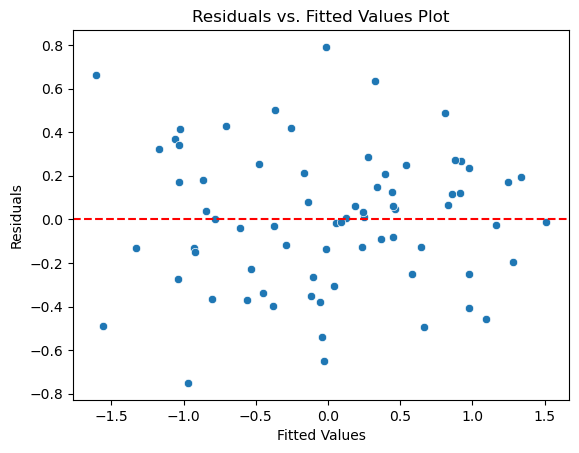

Breusch-Pagan test statistic: 15.241797352196564, p-value: 0.12349188336577603
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


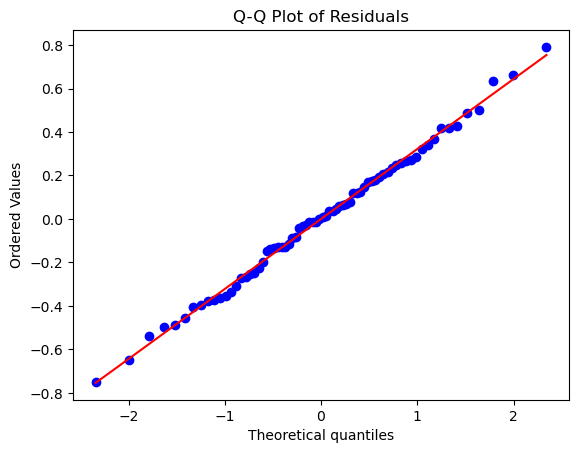

Shapiro-Wilk Test Results:
Statistic: 0.9956514835357666
p-value: 0.9976059198379517
Residuals are normally distributed (fail to reject null hypothesis)


In [172]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavgBMIz= mod_EAHsavgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavgBMIz = durbin_watson(residuals_EAHsavgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavgBMIz)
if 0 < dw_statistic_EAHsavgBMIz< 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavgBMIz.values, i) for i in range(X_EAHsavgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavgBMIz.fittedvalues, y=residuals_EAHsavgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()


bp_test = het_breuschpagan(residuals_EAHsavgBMIz,  mod_EAHsavgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)") 

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavgBMIz, p_value_EAHsavgBMIz = shapiro(residuals_EAHsavgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavgBMIz)
print("p-value:", p_value_EAHsavgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsavgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Partial Regression Plots: Baseline Intake (kcal) vs Follow-up adiposity (FMI)

In [173]:
# Calculate the scaled standard error for intake values
sd_meal_g = df['v1_meal_g'].std()
sd_eah_g = df['v1_eah_g'].std()
sd_eah_sweet_g = df['v1_eah_sweet_g'].std()
sd_eah_sav_g = df['v1_eah_sav_g'].std()

sd_meal_kcal = df['v1_meal_kcal'].std()
sd_eah_kcal = df['v1_eah_kcal'].std()
sd_eah_sweet_kcal = df['v1_eah_sweet_kcal'].std()
sd_eah_sav_kcal = df['v1_eah_sav_kcal'].std()

sd_FMI = df['v7_FMI'].std()

In [174]:
# define a function to compute the change in FMI for a 100 kcal increase
def change_in_FMI_for_100kcal_increase(coef, sd_FMI, sd_predictor):
    return coef * sd_FMI * (100/sd_predictor)

# Extract coefficients from the models
# Assuming each model has only one predictor, the coefficient will be for that predictor
coef_meal_fmi_kcal = mod_mealkcalFMI.params['v1_meal_kcal']
coef_eah_fmi_kcal = mod_EAHkcalFMI.params['v1_eah_kcal']
coef_eah_sweet_fmi_kcal = mod_EAHsweetkcalFMI.params['v1_eah_sweet_kcal']
coef_eah_sav_fmi_kcal = mod_EAHsavkcalFMI.params['v1_eah_sav_kcal']

# Calculate the change in FMI for a 100 kcal increase
change_meal_fmi_kcal = change_in_FMI_for_100kcal_increase(coef_meal_fmi_kcal, sd_FMI, sd_meal_kcal)
change_eah_fmi_kcal = change_in_FMI_for_100kcal_increase(coef_eah_fmi_kcal, sd_FMI, sd_eah_kcal)
change_eah_sweet_fmi_kcal = change_in_FMI_for_100kcal_increase(coef_eah_sweet_fmi_kcal, sd_FMI, sd_eah_sweet_kcal)
change_eah_sav_fmi_kcal= change_in_FMI_for_100kcal_increase(coef_eah_sav_fmi_kcal, sd_FMI, sd_eah_sav_kcal)

print("Change in FMI for 100 kcal increase in:")
print("Meal kcal:", change_meal_fmi_kcal)
print("EAH kcal:", change_eah_fmi_kcal)
print("EAH sweet kcal:", change_eah_sweet_fmi_kcal)
print("EAH sav kcal:", change_eah_sav_fmi_kcal)

Change in FMI for 100 kcal increase in:
Meal kcal: -0.009339547288890072
EAH kcal: 0.10941352742415753
EAH sweet kcal: 0.14378205057914137
EAH sav kcal: 0.04120327932987998


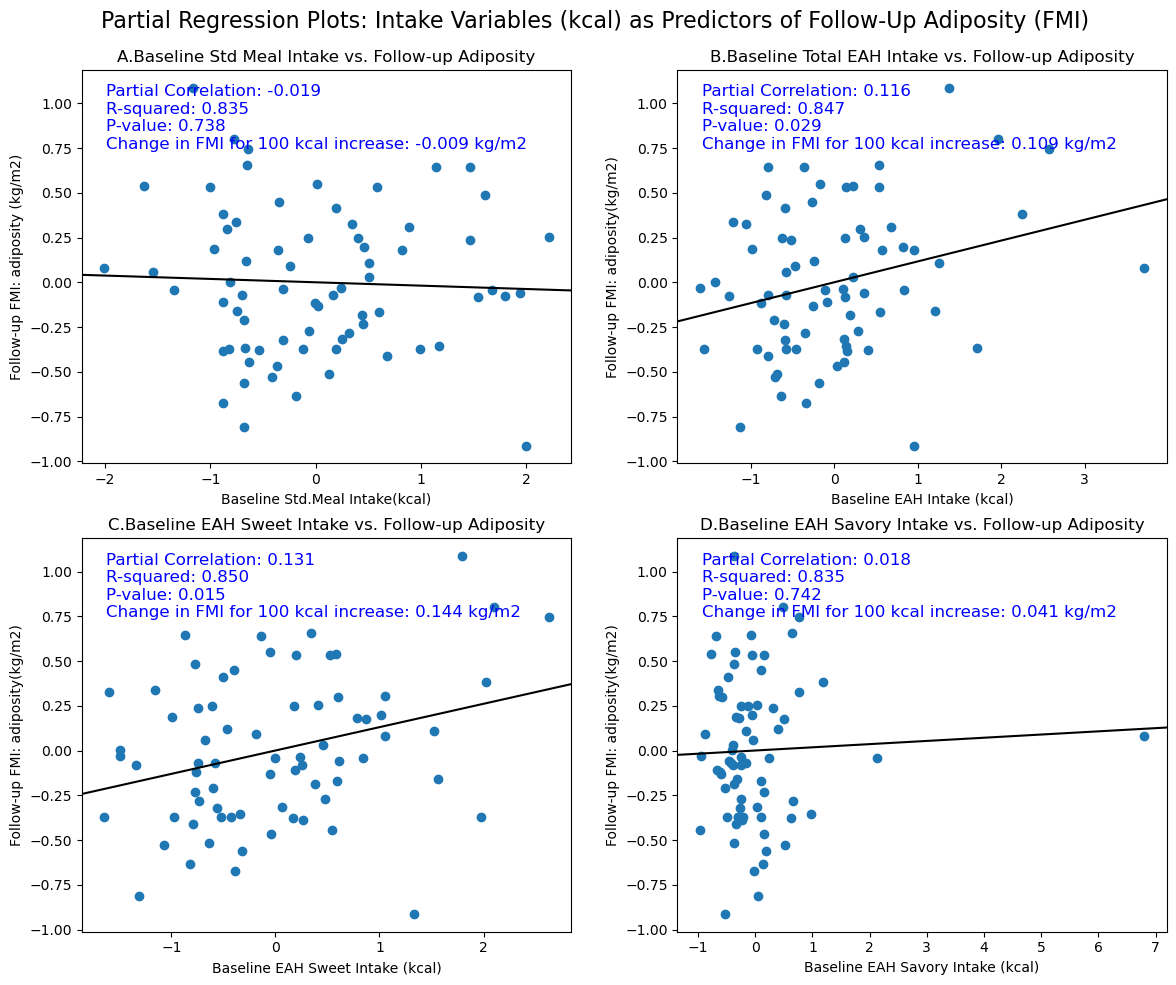

In [175]:
# partial reg plots (intake kcal vs v7_FMI)
# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Partial regression meal (kcal) vs FMI
plot1 = sm.graphics.plot_partregress('v7_FMI', 'v1_meal_kcal', ['v1_FMI','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[0, 0])
axes[0, 0].set_xlabel("Baseline Std.Meal Intake(kcal)")
axes[0, 0].set_ylabel("Follow-up FMI: adiposity (kg/m2)")
axes[0, 0].set_title("A.Baseline Std Meal Intake vs. Follow-up Adiposity")
axes[0, 0].annotate(f"Partial Correlation: {mod_mealkcalFMI.params['v1_meal_kcal']:.3f}\nR-squared: {mod_mealkcalFMI.rsquared:.3f}\nP-value: {mod_mealkcalFMI.pvalues['v1_meal_kcal']:.3f}\nChange in FMI for 100 kcal increase: {change_meal_fmi_kcal:.3f} kg/m2", xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH total (kcal) vs FMI
plot2 = sm.graphics.plot_partregress('v7_FMI', 'v1_eah_kcal', ['v1_FMI', 'sex','risk_status_mom', 'income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[0, 1])
axes[0, 1].set_xlabel("Baseline EAH Intake (kcal)")
axes[0, 1].set_ylabel("Follow-up FMI: adiposity(kg/m2)")
axes[0, 1].set_title("B.Baseline Total EAH Intake vs. Follow-up Adiposity")
axes[0, 1].annotate(f"Partial Correlation: {mod_EAHkcalFMI.params['v1_eah_kcal']:.3f}\nR-squared: {mod_EAHkcalFMI.rsquared:.3f}\nP-value: {mod_EAHkcalFMI.pvalues['v1_eah_kcal']:.3f}\nChange in FMI for 100 kcal increase: {change_eah_fmi_kcal:.3f} kg/m2", xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH sweet (kcal) vs FMI
sm.graphics.plot_partregress('v7_FMI', 'v1_eah_sweet_kcal', ['v1_FMI', 'sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[1, 0])
axes[1, 0].set_xlabel("Baseline EAH Sweet Intake (kcal)")
axes[1, 0].set_ylabel("Follow-up FMI: adiposity(kg/m2)")
axes[1, 0].set_title("C.Baseline EAH Sweet Intake vs. Follow-up Adiposity")
axes[1, 0].annotate(f"Partial Correlation: {mod_EAHsweetkcalFMI.params['v1_eah_sweet_kcal']:.3f}\nR-squared: {mod_EAHsweetkcalFMI.rsquared:.3f}\nP-value: {mod_EAHsweetkcalFMI.pvalues['v1_eah_sweet_kcal']:.3f}\nChange in FMI for 100 kcal increase: {change_eah_sweet_fmi_kcal:.3f} kg/m2", xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH savory (kcal) vs FMI
sm.graphics.plot_partregress('v7_FMI', 'v1_eah_sav_kcal', ['v1_FMI', 'sex','risk_status_mom', 'income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[1, 1])
axes[1, 1].set_xlabel("Baseline EAH Savory Intake (kcal)")
axes[1, 1].set_ylabel("Follow-up FMI: adiposity(kg/m2)")
axes[1, 1].set_title("D.Baseline EAH Savory Intake vs. Follow-up Adiposity")
axes[1, 1].annotate(f"Partial Correlation: {mod_EAHsavkcalFMI.params['v1_eah_sav_kcal']:.3f}\nR-squared: {mod_EAHsavkcalFMI.rsquared:.3f}\nP-value: {mod_EAHsavkcalFMI.pvalues['v1_eah_sav_kcal']:.3f}\nChange in FMI for 100 kcal increase: {change_eah_sav_fmi_kcal:.3f} kg/m2", xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(
    "Partial Regression Plots: Intake Variables (kcal) as Predictors of Follow-Up Adiposity (FMI)", fontsize=16)
plt.show()

## Partial Regression Plots: Baseline Intake (kcal) vs Follow-up weight status (BMIz)

In [176]:
# Extract the standard deviation only for predictor variables
sd_meal_kcal = df['v1_meal_kcal'].std()
sd_eah_kcal = df['v1_eah_kcal'].std()
sd_eah_sweet_kcal = df['v1_eah_sweet_kcal'].std()
sd_eah_sav_kcal = df['v1_eah_sav_kcal'].std()

# modify the function to compute the change in v7_bmi_z for a 100 kcal increase
def change_in_bmi_z_for_100kcal_increase(coef, sd_predictor):
    return coef * (100/sd_predictor)

# Extract coefficients from the models
coef_meal_bmi_kcal = mod_mealkcalBMIz.params['v1_meal_kcal']
coef_eah_bmi_kcal = mod_EAHkcalBMIz.params['v1_eah_kcal']
coef_eah_sweet_bmi_kcal = mod_EAHsweetkcalBMIz.params['v1_eah_sweet_kcal']
coef_eah_sav_bmi_kcal = mod_EAHsavkcalBMIz.params['v1_eah_sav_kcal']

# Calculate the change in v7_bmi_z for a 100 kcal increase
change_meal_bmi_kcal = change_in_bmi_z_for_100kcal_increase(coef_meal_bmi_kcal, sd_meal_kcal)
change_eah_bmi_kcal = change_in_bmi_z_for_100kcal_increase(coef_eah_bmi_kcal, sd_eah_kcal)
change_eah_sweet_bmi_kcal = change_in_bmi_z_for_100kcal_increase(coef_eah_sweet_bmi_kcal, sd_eah_sweet_kcal)
change_eah_sav_bmi_kcal = change_in_bmi_z_for_100kcal_increase(coef_eah_sav_bmi_kcal, sd_eah_sav_kcal)

print("Change in v7_bmi_z for 100 kcal increase in:")
print("Meal kcal:", change_meal_bmi_kcal)
print("EAH kcal:", change_eah_bmi_kcal)
print("EAH sweet kcal:", change_eah_sweet_bmi_kcal)
print("EAH sav kcal:", change_eah_sav_bmi_kcal)

Change in v7_bmi_z for 100 kcal increase in:
Meal kcal: 0.01506923279617885
EAH kcal: 0.031862513923464716
EAH sweet kcal: 0.05535997975256038
EAH sav kcal: -0.02606329415253712


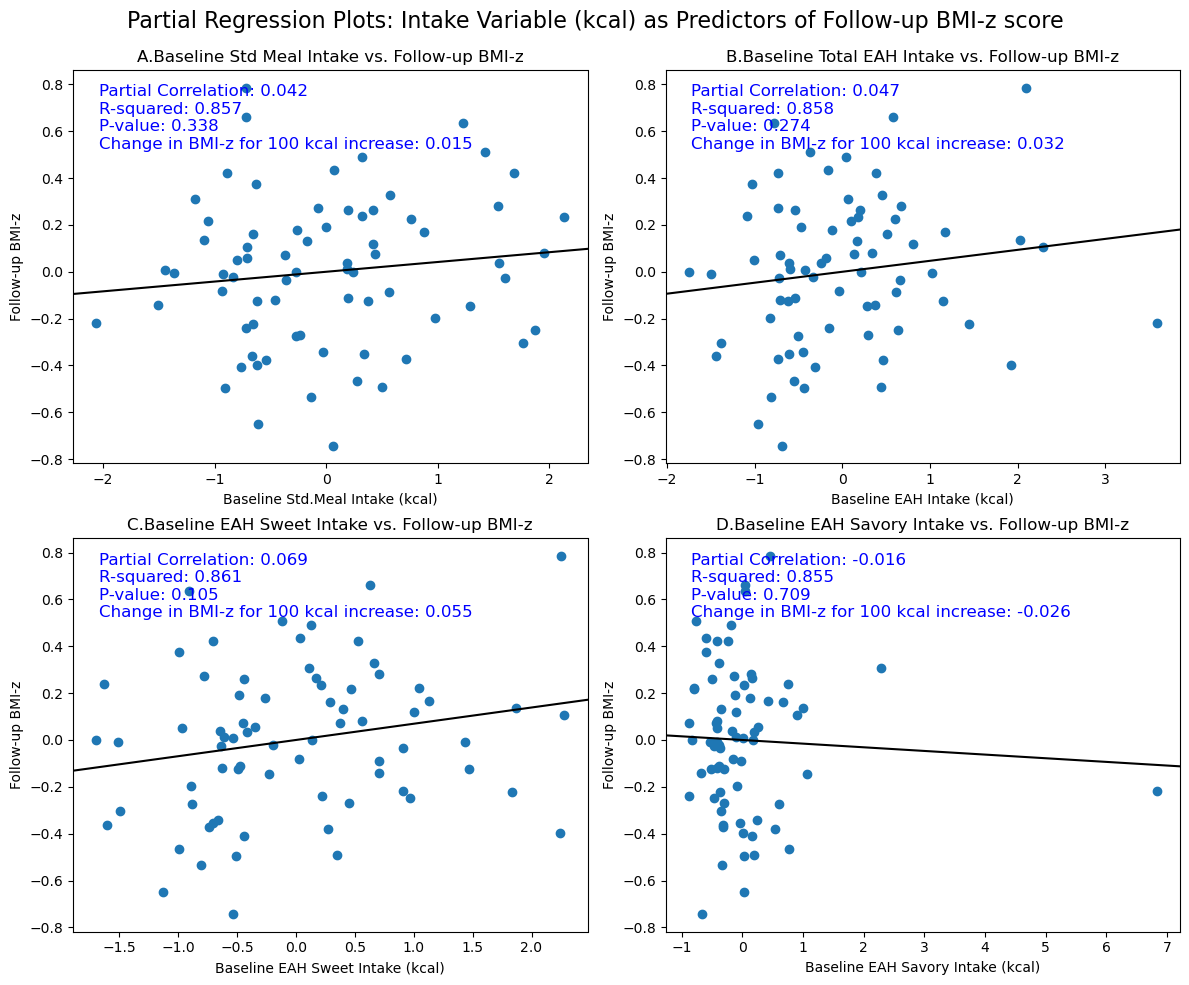

In [177]:
# partial reg plots (intake kcal vs v7_BMIz)
# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Partial regression meal (kcal) vs BMIz
plot1 = sm.graphics.plot_partregress('v7_bmi_z', 'v1_meal_kcal', ['bmi_z','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[0, 0])
axes[0, 0].set_xlabel("Baseline Std.Meal Intake (kcal)")
axes[0, 0].set_ylabel("Follow-up BMI-z")
axes[0, 0].set_title("A.Baseline Std Meal Intake vs. Follow-up BMI-z")
axes[0, 0].annotate(f"Partial Correlation: {mod_mealkcalBMIz.params['v1_meal_kcal']:.3f}\nR-squared: {mod_mealkcalBMIz.rsquared:.3f}\nP-value: {mod_mealkcalBMIz.pvalues['v1_meal_kcal']:.3f}\nChange in BMI-z for 100 kcal increase: {change_meal_bmi_kcal:.3f}", xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH total (kcal) vs BMIz
plot2 = sm.graphics.plot_partregress('v7_bmi_z', 'v1_eah_kcal', ['bmi_z','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'],  data=df_linear_reg, obs_labels=False, ax=axes[0, 1])
axes[0, 1].set_xlabel("Baseline EAH Intake (kcal)")
axes[0, 1].set_ylabel("Follow-up BMI-z")
axes[0, 1].set_title("B.Baseline Total EAH Intake vs. Follow-up BMI-z")
axes[0, 1].annotate(f"Partial Correlation: {mod_EAHkcalBMIz.params['v1_eah_kcal']:.3f}\nR-squared: {mod_EAHkcalBMIz.rsquared:.3f}\nP-value: {mod_EAHkcalBMIz.pvalues['v1_eah_kcal']:.3f}\nChange in BMI-z for 100 kcal increase: {change_eah_bmi_kcal:.3f}", xy=(0.05, 0.80), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH sweet (kcal) vs BMIz
sm.graphics.plot_partregress('v7_bmi_z', 'v1_eah_sweet_kcal', ['bmi_z','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'],  data=df_linear_reg, obs_labels=False, ax=axes[1, 0])
axes[1, 0].set_xlabel("Baseline EAH Sweet Intake (kcal)")
axes[1, 0].set_ylabel("Follow-up BMI-z")
axes[1, 0].set_title("C.Baseline EAH Sweet Intake vs. Follow-up BMI-z")
axes[1, 0].annotate(f"Partial Correlation: {mod_EAHsweetkcalBMIz.params['v1_eah_sweet_kcal']:.3f}\nR-squared: {mod_EAHsweetkcalBMIz.rsquared:.3f}\nP-value: {mod_EAHsweetkcalBMIz.pvalues['v1_eah_sweet_kcal']:.3f}\nChange in BMI-z for 100 kcal increase: {change_eah_sweet_bmi_kcal:.3f}", xy=(0.05, 0.80), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH savory (kcal) vs FMI
sm.graphics.plot_partregress('v7_bmi_z', 'v1_eah_sav_kcal', ['bmi_z','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'],  data=df_linear_reg, obs_labels=False, ax=axes[1, 1])
axes[1, 1].set_xlabel("Baseline EAH Savory Intake (kcal)")
axes[1, 1].set_ylabel("Follow-up BMI-z")
axes[1, 1].set_title("D.Baseline EAH Savory Intake vs. Follow-up BMI-z")
axes[1, 1].annotate(f"Partial Correlation: {mod_EAHsavkcalBMIz.params['v1_eah_sav_kcal']:.3f}\nR-squared: {mod_EAHsavkcalBMIz.rsquared:.3f}\nP-value: {mod_EAHsavkcalBMIz.pvalues['v1_eah_sav_kcal']:.3f}\nChange in BMI-z for 100 kcal increase: {change_eah_sav_bmi_kcal:.3f}", xy=(0.05, 0.80), xycoords='axes fraction', fontsize=12, color='blue')

fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Partial Regression Plots: Intake Variable (kcal) as Predictors of Follow-up BMI-z score", fontsize=16)
plt.show()


## Partial Regression Plots: Baseline Intake (gram) vs Follow-up adiposity (FMI)

In [178]:
# Extract standard deviations from original dataframe
sd_FMI = df['v7_FMI'].std()
sd_meal_g = df['v1_meal_g'].std()
sd_eah_g = df['v1_eah_g'].std()
sd_eah_sweet_g = df['v1_eah_sweet_g'].std()
sd_eah_sav_g = df['v1_eah_sav_g'].std()

# Function to compute the change in FMI for a 100g increase
def change_in_FMI_for_100g_increase(coef, sd_FMI, sd_predictor):
    return coef * sd_FMI * (100/sd_predictor)

# Extract coefficients from the models
coef_meal_g_fmi = mod_mealgFMI.params['v1_meal_g']  # Assuming the predictors in your models are now the gram columns
coef_eah_g_fmi = mod_EAHgFMI.params['v1_eah_g']
coef_eah_sweet_g_fmi = mod_EAHsweetgFMI.params['v1_eah_sweet_g']
coef_eah_sav_g_fmi = mod_EAHsavgFMI.params['v1_eah_sav_g']

# Calculate the change in FMI for a 100g increase
change_meal_g_fmi = change_in_FMI_for_100g_increase(coef_meal_g_fmi, sd_FMI, sd_meal_g)
change_eah_g_fmi = change_in_FMI_for_100g_increase(coef_eah_g_fmi, sd_FMI, sd_eah_g)
change_eah_sweet_g_fmi = change_in_FMI_for_100g_increase(coef_eah_sweet_g_fmi, sd_FMI, sd_eah_sweet_g)
change_eah_sav_g_fmi = change_in_FMI_for_100g_increase(coef_eah_sav_g_fmi, sd_FMI, sd_eah_sav_g)

print("Change in FMI for 100g increase in:")
print("Meal g:", change_meal_g_fmi)
print("EAH g:", change_eah_g_fmi)
print("EAH sweet g:", change_eah_sweet_g_fmi)
print("EAH sav g:", change_eah_sav_g_fmi)


Change in FMI for 100g increase in:
Meal g: 0.0031491345866848986
EAH g: 0.047062490370903244
EAH sweet g: 0.6749033266203227
EAH sav g: 0.23396252973892417


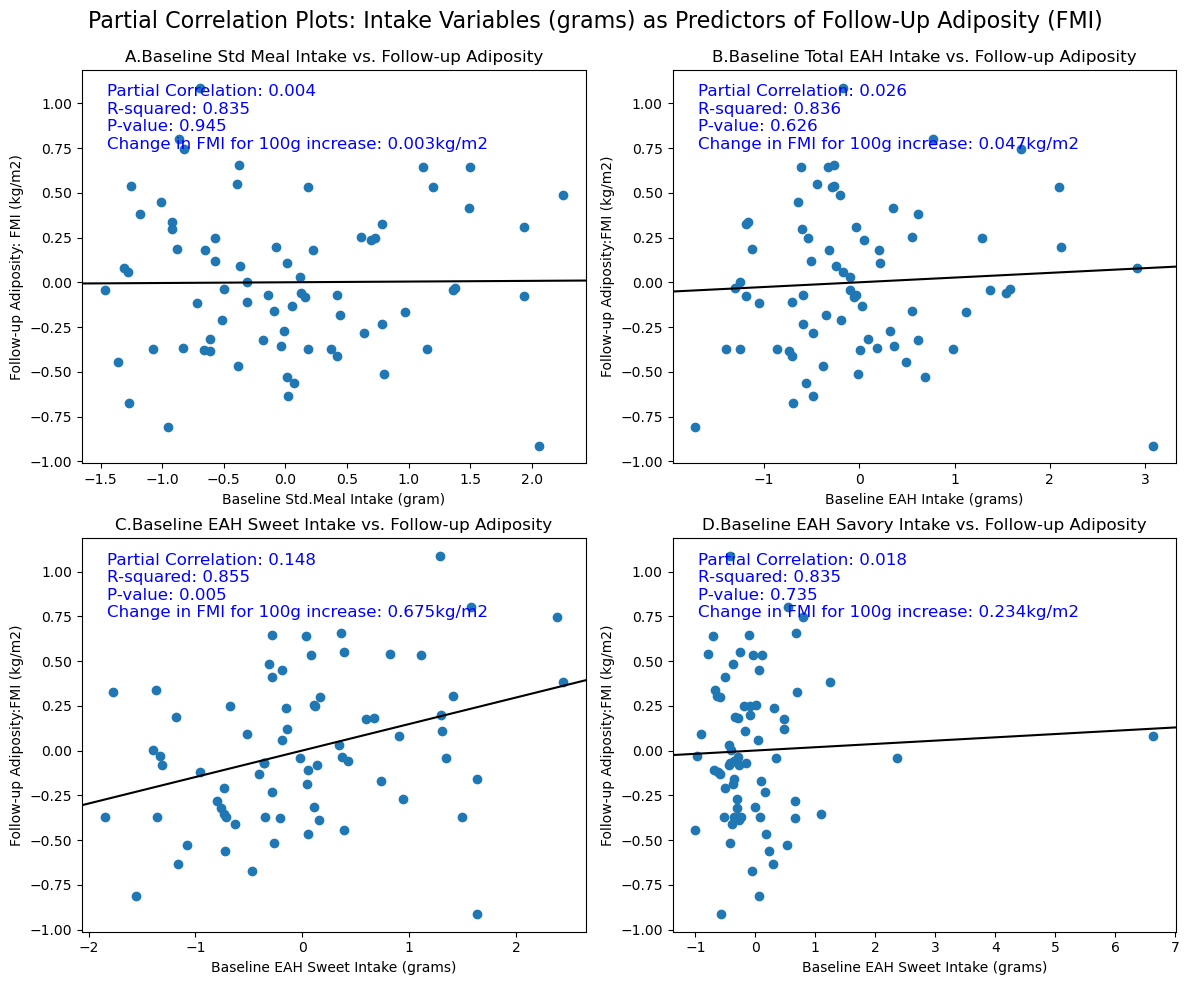

In [179]:
# partial reg plots (intake gram vs v7_FMI)
# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Partial regression meal (g) vs BMIz
plot1 = sm.graphics.plot_partregress('v7_FMI', 'v1_meal_g', ['v1_FMI','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[0, 0])
axes[0, 0].set_xlabel("Baseline Std.Meal Intake (gram)")
axes[0, 0].set_ylabel("Follow-up Adiposity: FMI (kg/m2)")
axes[0, 0].set_title("A.Baseline Std Meal Intake vs. Follow-up Adiposity")
axes[0, 0].annotate(f"Partial Correlation: {mod_mealgFMI.params['v1_meal_g']:.3f}\nR-squared: {mod_mealgFMI.rsquared:.3f}\nP-value: {mod_mealgFMI.pvalues['v1_meal_g']:.3f}\nChange in FMI for 100g increase: {change_meal_g_fmi:.3f}kg/m2", xy=(0.05, 0.80), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH total (gram) vs FMI
plot2 = sm.graphics.plot_partregress('v7_FMI', 'v1_eah_g', ['v1_FMI','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[0, 1])
axes[0, 1].set_xlabel("Baseline EAH Intake (grams)")
axes[0, 1].set_ylabel("Follow-up Adiposity:FMI (kg/m2)")
axes[0, 1].set_title("B.Baseline Total EAH Intake vs. Follow-up Adiposity")
axes[0, 1].annotate(f"Partial Correlation: {mod_EAHgFMI.params['v1_eah_g']:.3f}\nR-squared: {mod_EAHgFMI.rsquared:.3f}\nP-value: {mod_EAHgFMI.pvalues['v1_eah_g']:.3f}\nChange in FMI for 100g increase: {change_eah_g_fmi:.3f}kg/m2", xy=(
    0.05, 0.80), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH sweet (gram) vs FMI
sm.graphics.plot_partregress('v7_FMI', 'v1_eah_sweet_g', ['v1_FMI','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[1, 0])
axes[1, 0].set_xlabel("Baseline EAH Sweet Intake (grams)")
axes[1, 0].set_ylabel("Follow-up Adiposity:FMI (kg/m2)")
axes[1, 0].set_title("C.Baseline EAH Sweet Intake vs. Follow-up Adiposity")
axes[1, 0].annotate(f"Partial Correlation: {mod_EAHsweetgFMI.params['v1_eah_sweet_g']:.3f}\nR-squared: {mod_EAHsweetgFMI.rsquared:.3f}\nP-value: {mod_EAHsweetgFMI.pvalues['v1_eah_sweet_g']:.3f}\nChange in FMI for 100g increase: {change_eah_sweet_g_fmi:.3f}kg/m2", xy=(
    0.05, 0.80), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH savory (gram) vs FMI
sm.graphics.plot_partregress('v7_FMI', 'v1_eah_sav_g', ['v1_FMI','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[1, 1])
axes[1, 1].set_xlabel("Baseline EAH Sweet Intake (grams)")
axes[1, 1].set_ylabel("Follow-up Adiposity:FMI (kg/m2)")
axes[1, 1].set_title("D.Baseline EAH Savory Intake vs. Follow-up Adiposity")
axes[1, 1].annotate(f"Partial Correlation: {mod_EAHsavgFMI.params['v1_eah_sav_g']:.3f}\nR-squared: {mod_EAHsavgFMI.rsquared:.3f}\nP-value: {mod_EAHsavgFMI.pvalues['v1_eah_sav_g']:.3f}\nChange in FMI for 100g increase: {change_eah_sav_g_fmi:.3f}kg/m2", xy=(
    0.05, 0.80), xycoords='axes fraction', fontsize=12, color='blue')

fig.tight_layout()
plt.suptitle(
    "Partial Correlation Plots: Intake Variables (grams) as Predictors of Follow-Up Adiposity (FMI)", fontsize=16)
plt.subplots_adjust(top=0.92)

## Partial Regression Plots: Baseline Intake (gram) vs Follow-up weight status (BMIz)

In [180]:
# Extract the standard deviation only for predictor variables
sd_meal_g = df['v1_meal_g'].std()
sd_eah_g= df['v1_eah_g'].std()
sd_eah_sweet_g = df['v1_eah_sweet_g'].std()
sd_eah_sav_g = df['v1_eah_sav_g'].std()

# modify the function to compute the change in v7_bmi_z for a 100 kcal increase
def change_in_bmi_z_for_100g_increase(coef, sd_predictor):
    return coef * (100/sd_predictor)

# Extract coefficients from the models
coef_meal_bmi_g = mod_mealgBMIz.params['v1_meal_g']
coef_eah_bmi_g = mod_EAHgBMIz.params['v1_eah_g']
coef_eah_sweet_bmi_g = mod_EAHsweetgBMIz.params['v1_eah_sweet_g']
coef_eah_sav_bmi_g = mod_EAHsavgBMIz.params['v1_eah_sav_g']

# Calculate the change in v7_bmi_z for a 100 kcal increase
change_meal_bmi_g = change_in_bmi_z_for_100kcal_increase(coef_meal_bmi_g, sd_meal_g)
change_eah_bmi_g = change_in_bmi_z_for_100kcal_increase(coef_eah_bmi_g, sd_eah_g)
change_eah_sweet_bmi_g = change_in_bmi_z_for_100kcal_increase(coef_eah_sweet_bmi_g, sd_eah_sweet_g)
change_eah_sav_bmi_g = change_in_bmi_z_for_100kcal_increase(coef_eah_sav_bmi_g, sd_eah_sav_g)

print("Change in v7_bmi_z for 100 kcal increase in:")
print("Meal kcal:", change_meal_bmi_g)
print("EAH kcal:", change_eah_bmi_g)
print("EAH sweet kcal:", change_eah_sweet_bmi_g)
print("EAH sav kcal:", change_eah_sav_bmi_g)

Change in v7_bmi_z for 100 kcal increase in:
Meal kcal: 0.03160687289725124
EAH kcal: 0.07489591640770775
EAH sweet kcal: 0.27829355779103754
EAH sav kcal: -0.11200121344067725


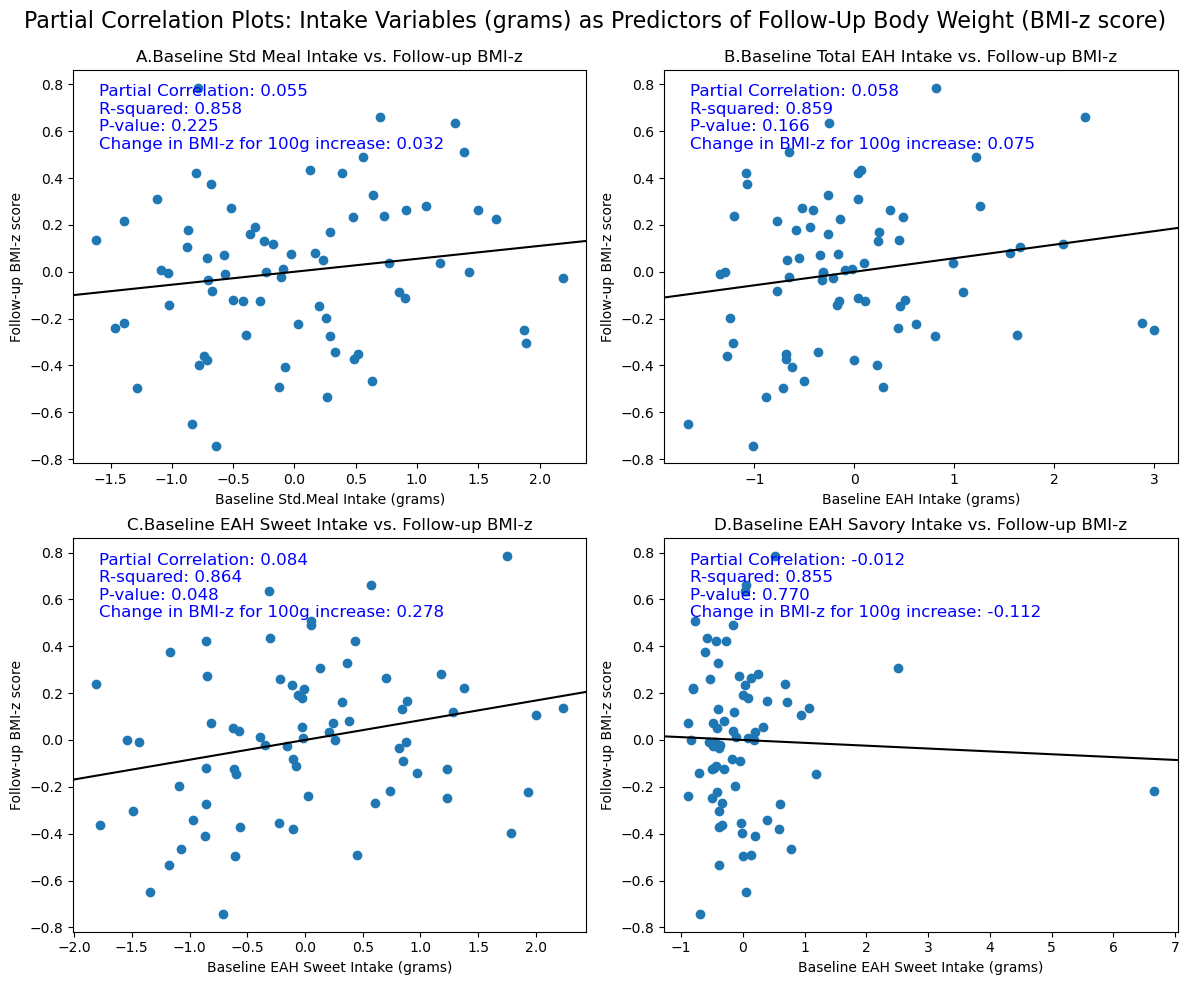

In [181]:
# partial reg plots (intake gram vs v7_bmi_z)
# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Partial regression meal (gram) vs FMI
plot1 = sm.graphics.plot_partregress('v7_bmi_z', 'v1_meal_g', ['bmi_z','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[0, 0])
axes[0, 0].set_xlabel("Baseline Std.Meal Intake (grams)")
axes[0, 0].set_ylabel("Follow-up BMI-z score")
axes[0, 0].set_title("A.Baseline Std Meal Intake vs. Follow-up BMI-z")
axes[0, 0].annotate(f"Partial Correlation: {mod_mealgBMIz.params['v1_meal_g']:.3f}\nR-squared: {mod_mealgBMIz.rsquared:.3f}\nP-value: {mod_mealgBMIz.pvalues['v1_meal_g']:.3f}\nChange in BMI-z for 100g increase: {change_meal_bmi_g:.3f}", xy=(
    0.05, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH total (gram) vs FMI
plot2 = sm.graphics.plot_partregress('v7_bmi_z', 'v1_eah_g', ['bmi_z','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[0, 1])
axes[0, 1].set_xlabel("Baseline EAH Intake (grams)")
axes[0, 1].set_ylabel("Follow-up BMI-z score")
axes[0, 1].set_title("B.Baseline Total EAH Intake vs. Follow-up BMI-z")
axes[0, 1].annotate(f"Partial Correlation: {mod_EAHgBMIz.params['v1_eah_g']:.3f}\nR-squared: {mod_EAHgBMIz.rsquared:.3f}\nP-value: {mod_EAHgBMIz.pvalues['v1_eah_g']:.3f}\nChange in BMI-z for 100g increase: {change_eah_bmi_g:.3f}", xy=(
    0.05, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH sweet (gram) vs FMI
sm.graphics.plot_partregress('v7_bmi_z', 'v1_eah_sweet_g', ['bmi_z','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[1, 0])
axes[1, 0].set_xlabel("Baseline EAH Sweet Intake (grams)")
axes[1, 0].set_ylabel("Follow-up BMI-z score")
axes[1, 0].set_title("C.Baseline EAH Sweet Intake vs. Follow-up BMI-z")
axes[1, 0].annotate(f"Partial Correlation: {mod_EAHsweetgBMIz.params['v1_eah_sweet_g']:.3f}\nR-squared: {mod_EAHsweetgBMIz.rsquared:.3f}\nP-value: {mod_EAHsweetgBMIz.pvalues['v1_eah_sweet_g']:.3f}\nChange in BMI-z for 100g increase: {change_eah_sweet_bmi_g:.3f}", xy=(
    0.05, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

# Partial regression EAH savory (gram) vs FMI
sm.graphics.plot_partregress('v7_bmi_z', 'v1_eah_sav_g', ['bmi_z','sex','risk_status_mom','income','parent_ed','tanner_change_0','tanner_change_1', 'tanner_change_2','age_diff'], data=df_linear_reg, obs_labels=False, ax=axes[1, 1])
axes[1, 1].set_xlabel("Baseline EAH Sweet Intake (grams)")
axes[1, 1].set_ylabel("Follow-up BMI-z score")
axes[1, 1].set_title("D.Baseline EAH Savory Intake vs. Follow-up BMI-z")
axes[1, 1].annotate(f"Partial Correlation: {mod_EAHsavgBMIz.params['v1_eah_sav_g']:.3f}\nR-squared: {mod_EAHsavgBMIz.rsquared:.3f}\nP-value: {mod_EAHsavgBMIz.pvalues['v1_eah_sav_g']:.3f}\nChange in BMI-z for 100g increase: {change_eah_sav_bmi_g:.3f}", xy=(
    0.05, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

fig.tight_layout()
plt.suptitle("Partial Correlation Plots: Intake Variables (grams) as Predictors of Follow-Up Body Weight (BMI-z score)", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()


# SE reverse-scaling

In [182]:
scaled_se_meal_fmi_kcal = mod_mealkcalFMI.bse['v1_meal_kcal'] * sd_FMI * (100 / sd_meal_kcal)
scaled_se_eah_fmi_kcal = mod_EAHkcalFMI.bse['v1_eah_kcal'] * sd_FMI * (100 / sd_eah_kcal)
scaled_se_eah_sweet_fmi_kcal = mod_EAHsweetkcalFMI.bse['v1_eah_sweet_kcal'] * sd_FMI * (100 / sd_eah_sweet_kcal)
scaled_se_eah_sav_fmi_kcal = mod_EAHsavkcalFMI.bse['v1_eah_sav_kcal'] * sd_FMI * (100 / sd_eah_sav_kcal)


scaled_se_meal_fmi_g = mod_mealgFMI.bse['v1_meal_g'] * sd_FMI * (100 / sd_meal_g)
scaled_se_eah_fmi_g = mod_EAHgFMI.bse['v1_eah_g'] * sd_FMI * (100 / sd_eah_g)
scaled_se_eah_sweet_fmi_g = mod_EAHsweetgFMI.bse['v1_eah_sweet_g'] * sd_FMI * (100 / sd_eah_sweet_g)
scaled_se_eah_sav_fmi_g = mod_EAHsavgFMI.bse['v1_eah_sav_g'] * sd_FMI * (100 / sd_eah_sav_g)


scaled_se_meal_bmiz_kcal = mod_mealkcalBMIz.bse['v1_meal_kcal'] * (100 / sd_meal_kcal)
scaled_se_eah_bmiz_kcal = mod_EAHkcalBMIz.bse['v1_eah_kcal'] * (100 / sd_eah_kcal)
scaled_se_eah_sweet_bmiz_kcal = mod_EAHsweetkcalBMIz.bse['v1_eah_sweet_kcal'] * (100 / sd_eah_sweet_kcal)
scaled_se_eah_sav_bmiz_kcal = mod_EAHsavkcalBMIz.bse['v1_eah_sav_kcal'] * (100 / sd_eah_sav_kcal)

scaled_se_meal_bmiz_g = mod_mealgBMIz.bse['v1_meal_g'] * (100 / sd_meal_g)
scaled_se_eah_bmiz_g = mod_EAHgBMIz.bse['v1_eah_g'] * (100 / sd_eah_g)
scaled_se_eah_sweet_bmiz_g = mod_EAHsweetgBMIz.bse['v1_eah_sweet_g'] * (100 / sd_eah_sweet_g)
scaled_se_eah_sav_bmiz_g = mod_EAHsavgBMIz.bse['v1_eah_sav_g'] * (100 / sd_eah_sav_g)


print("Change in SE of FMI for 100 kcal increase in:")
print("SE of beta Meal kcal:{:.2f}".format(scaled_se_meal_fmi_kcal))
print("SE of beta EAH kcal:{:.2f}".format(scaled_se_eah_fmi_kcal))
print("SE of beta EAH sweet kcal:{:.2f}".format(scaled_se_eah_sweet_fmi_kcal))
print("SE of beta EAH sav kcal:{:.2f}".format(scaled_se_eah_sav_fmi_kcal))


print("Change in SE of FMI for 100 g increase in:")
print("SE of beta Meal g:{:.2f}".format(scaled_se_meal_fmi_g))
print("SE of beta EAH g:{:.2f}".format(scaled_se_eah_fmi_g))
print("SE of beta EAH sweet g:{:.2f}".format(scaled_se_eah_sweet_fmi_g))
print("SE of beta EAH sav g:{:.2f}".format(scaled_se_eah_sav_fmi_g))

print("Change in SE of BMIz for 100 kcal increase in:")
print("SE of beta Meal kcal:{:.2f}".format(scaled_se_meal_bmiz_kcal))
print("SE of beta EAH kcal:{:.2f}".format(scaled_se_eah_bmiz_kcal))
print("SE of beta EAH sweet kcal:{:.2f}".format(scaled_se_eah_sweet_bmiz_kcal))
print("SE of beta EAH sav kcal:{:.2f}".format(scaled_se_eah_sav_bmiz_kcal))

print("Change in SE of BMIz for 100 g increase in:")
print("SE of beta Meal g:{:.2f}".format(scaled_se_meal_bmiz_g))
print("SE of beta EAH g:{:.2f}".format(scaled_se_eah_bmiz_g))
print("SE of beta EAH sweet g:{:.2f}".format(scaled_se_eah_sweet_bmiz_g))
print("SE of beta EAH sav g:{:.2f}".format(scaled_se_eah_sav_bmiz_g))

Change in SE of FMI for 100 kcal increase in:
SE of beta Meal kcal:0.03
SE of beta EAH kcal:0.05
SE of beta EAH sweet kcal:0.06
SE of beta EAH sav kcal:0.12
Change in SE of FMI for 100 g increase in:
SE of beta Meal g:0.05
SE of beta EAH g:0.10
SE of beta EAH sweet g:0.23
SE of beta EAH sav g:0.69
Change in SE of BMIz for 100 kcal increase in:
SE of beta Meal kcal:0.02
SE of beta EAH kcal:0.03
SE of beta EAH sweet kcal:0.03
SE of beta EAH sav kcal:0.07
Change in SE of BMIz for 100 g increase in:
SE of beta Meal g:0.03
SE of beta EAH g:0.05
SE of beta EAH sweet g:0.14
SE of beta EAH sav g:0.38


## Scatterplots for baseline vs follow-up intake measures(kcal)

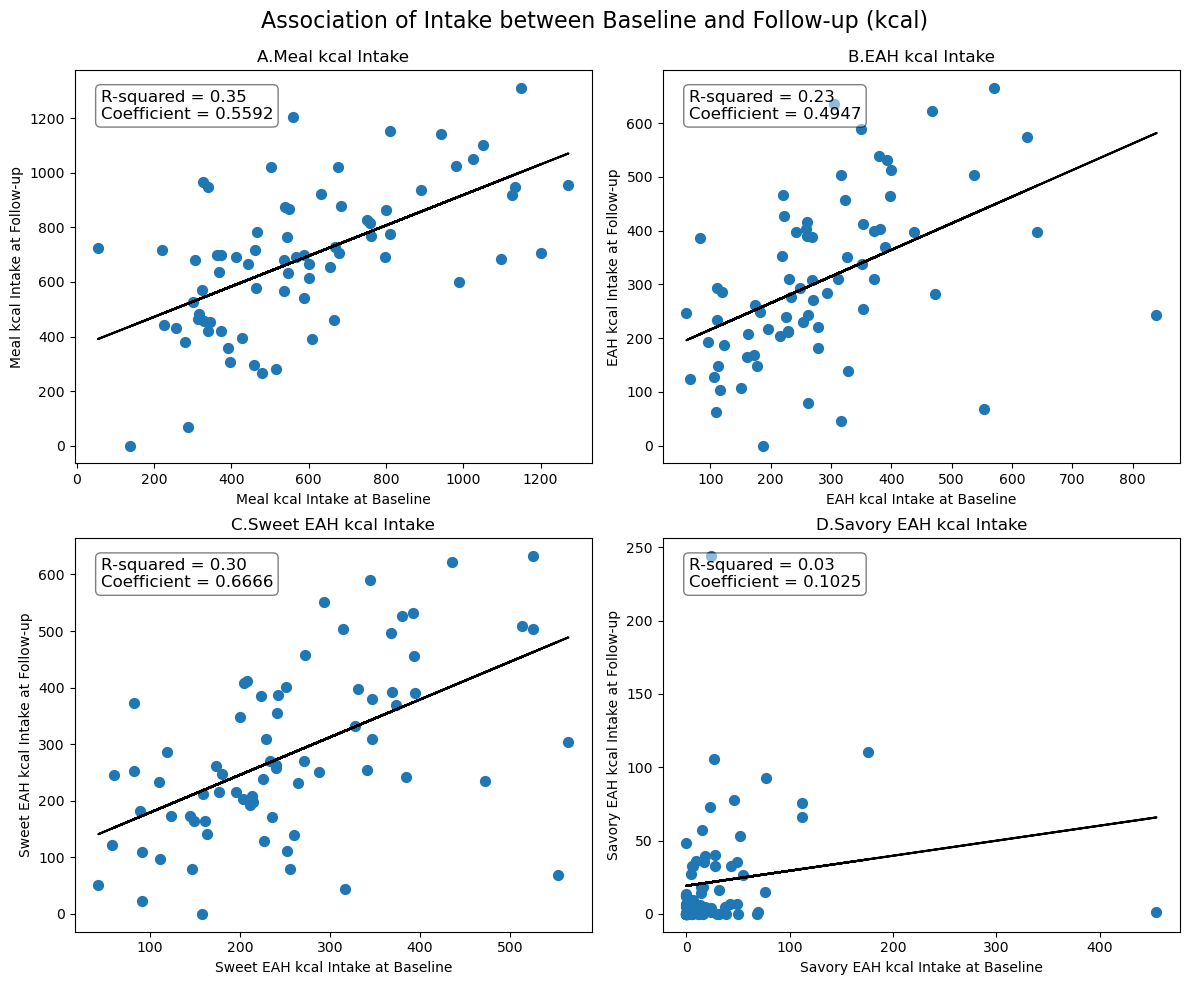

In [183]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Scatter Plot for Meal Intake
axs[0, 0].scatter(df['v1_meal_kcal'], df['v7_meal_kcal'], s=50)
axs[0, 0].set_xlabel('Meal kcal Intake at Baseline')
axs[0, 0].set_ylabel('Meal kcal Intake at Follow-up')
axs[0, 0].set_title('A.Meal kcal Intake')

# Fit a linear regression model for Meal Intake
x_meal = df['v1_meal_kcal']
y_meal = df['v7_meal_kcal']
coeff_meal = np.polyfit(x_meal, y_meal, 1)
polynomial_meal = np.poly1d(coeff_meal)
correlation_matrix_meal = np.corrcoef(x_meal, y_meal)
correlation_xy_meal = correlation_matrix_meal[0, 1]
r_squared_meal = correlation_xy_meal ** 2
textstr_meal = f'R-squared = {r_squared_meal:.2f}\nCoefficient = {coeff_meal[0]:.4f}'
axs[0, 0].text(0.05, 0.95, textstr_meal, transform=axs[0, 0].transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axs[0, 0].plot(x_meal, polynomial_meal(x_meal), color='black')

# Scatter Plot for EAH Intake
axs[0, 1].scatter(df['v1_eah_kcal'], df['v7_eah_kcal'], s=50)
axs[0, 1].set_xlabel('EAH kcal Intake at Baseline')
axs[0, 1].set_ylabel('EAH kcal Intake at Follow-up')
axs[0, 1].set_title('B.EAH kcal Intake')

# Fit a linear regression model for EAH Intake
x_eah = df['v1_eah_kcal']
y_eah = df['v7_eah_kcal']
coeff_eah = np.polyfit(x_eah, y_eah, 1)
polynomial_eah = np.poly1d(coeff_eah)
correlation_matrix_eah = np.corrcoef(x_eah, y_eah)
correlation_xy_eah = correlation_matrix_eah[0, 1]
r_squared_eah = correlation_xy_eah ** 2
textstr_eah = f'R-squared = {r_squared_eah:.2f}\nCoefficient = {coeff_eah[0]:.4f}'
axs[0, 1].text(0.05, 0.95, textstr_eah, transform=axs[0, 1].transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axs[0, 1].plot(x_eah, polynomial_eah(x_eah), color='black')


# Scatter Plot for Sweet EAH Intake
axs[1, 0].scatter(df['v1_eah_sweet_kcal'], df['v7_eah_sweet_kcal'], s=50)
axs[1, 0].set_xlabel('Sweet EAH kcal Intake at Baseline')
axs[1, 0].set_ylabel('Sweet EAH kcal Intake at Follow-up')
axs[1, 0].set_title('C.Sweet EAH kcal Intake')

# Fit a linear regression model for Sweet EAH Intake
x_sweet = df['v1_eah_sweet_kcal']
y_sweet = df['v7_eah_sweet_kcal']
coeff_sweet = np.polyfit(x_sweet, y_sweet, 1)
polynomial_sweet = np.poly1d(coeff_sweet)
correlation_matrix_sweet = np.corrcoef(x_sweet, y_sweet)
correlation_xy_sweet = correlation_matrix_sweet[0, 1]
r_squared_sweet = correlation_xy_sweet ** 2
textstr_sweet = f'R-squared = {r_squared_sweet:.2f}\nCoefficient = {coeff_sweet[0]:.4f}'
axs[1, 0].text(0.05, 0.95, textstr_sweet, transform=axs[1, 0].transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axs[1, 0].plot(x_sweet, polynomial_sweet(x_sweet), color='black')

# Scatter Plot for Savory EAH Intake
axs[1, 1].scatter(df['v1_eah_sav_kcal'], df['v7_eah_sav_kcal'], s=50)
axs[1, 1].set_xlabel('Savory EAH kcal Intake at Baseline')
axs[1, 1].set_ylabel('Savory EAH kcal Intake at Follow-up')
axs[1, 1].set_title('D.Savory EAH kcal Intake')

# Fit a linear regression model for Savory EAH Intake
x_savory = df['v1_eah_sav_kcal']
y_savory = df['v7_eah_sav_kcal']
coeff_savory = np.polyfit(x_savory, y_savory, 1)
polynomial_savory = np.poly1d(coeff_savory)
correlation_matrix_savory = np.corrcoef(x_savory, y_savory)
correlation_xy_savory = correlation_matrix_savory[0, 1]
r_squared_savory = correlation_xy_savory ** 2
textstr_savory = f'R-squared = {r_squared_savory:.2f}\nCoefficient = {coeff_savory[0]:.4f}'
axs[1, 1].text(0.05, 0.95, textstr_savory, transform=axs[1, 1].transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axs[1, 1].plot(x_savory, polynomial_savory(x_savory), color='black')

plt.tight_layout()
plt.suptitle(
    "Association of Intake between Baseline and Follow-up (kcal)", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

## Scatterplots for baseline vs follow-up intake measures(grams)

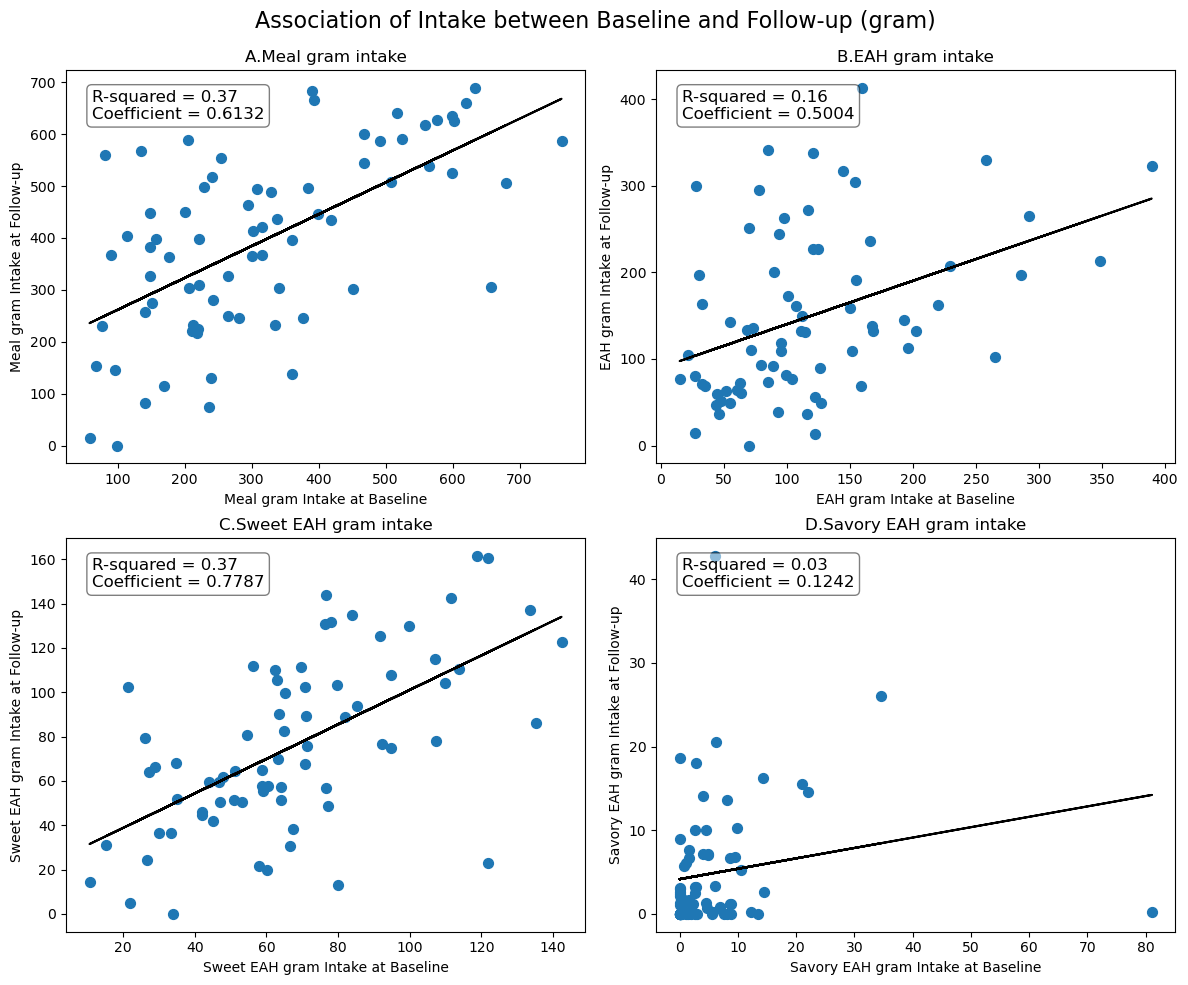

In [184]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Scatter Plot for Meal Intake
axs[0, 0].scatter(df['v1_meal_g'], df['v7_meal_g'], s=50)
axs[0, 0].set_xlabel('Meal gram Intake at Baseline')
axs[0, 0].set_ylabel('Meal gram Intake at Follow-up')
axs[0, 0].set_title('A.Meal gram intake')

# Fit a linear regression model for Meal Intake
x_meal = df['v1_meal_g']
y_meal = df['v7_meal_g']
coeff_meal = np.polyfit(x_meal, y_meal, 1)
polynomial_meal = np.poly1d(coeff_meal)
correlation_matrix_meal = np.corrcoef(x_meal, y_meal)
correlation_xy_meal = correlation_matrix_meal[0, 1]
r_squared_meal = correlation_xy_meal ** 2
textstr_meal = f'R-squared = {r_squared_meal:.2f}\nCoefficient = {coeff_meal[0]:.4f}'
axs[0, 0].text(0.05, 0.95, textstr_meal, transform=axs[0, 0].transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axs[0, 0].plot(x_meal, polynomial_meal(x_meal), color='black')# Scatter Plot for EAH Intake
axs[0, 1].scatter(df['v1_eah_g'], df['v7_eah_g'], s=50)
axs[0, 1].set_xlabel('EAH gram Intake at Baseline')
axs[0, 1].set_ylabel('EAH gram Intake at Follow-up')
axs[0, 1].set_title('B.EAH gram intake')

# Fit a linear regression model for EAH Intake
x_eah = df['v1_eah_g']
y_eah = df['v7_eah_g']
coeff_eah = np.polyfit(x_eah, y_eah, 1)
polynomial_eah = np.poly1d(coeff_eah)
correlation_matrix_eah = np.corrcoef(x_eah, y_eah)
correlation_xy_eah = correlation_matrix_eah[0, 1]
r_squared_eah = correlation_xy_eah ** 2
textstr_eah = f'R-squared = {r_squared_eah:.2f}\nCoefficient = {coeff_eah[0]:.4f}'
axs[0, 1].text(0.05, 0.95, textstr_eah, transform=axs[0, 1].transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axs[0, 1].plot(x_eah, polynomial_eah(x_eah), color='black')

# Scatter Plot for Sweet EAH Intake
axs[1, 0].scatter(df['v1_eah_sweet_g'], df['v7_eah_sweet_g'], s=50)
axs[1, 0].set_xlabel('Sweet EAH gram Intake at Baseline')
axs[1, 0].set_ylabel('Sweet EAH gram Intake at Follow-up')
axs[1, 0].set_title('C.Sweet EAH gram intake')

# Fit a linear regression model for Sweet EAH Intake
x_sweet = df['v1_eah_sweet_g']
y_sweet = df['v7_eah_sweet_g']
coeff_sweet = np.polyfit(x_sweet, y_sweet, 1)
polynomial_sweet = np.poly1d(coeff_sweet)
correlation_matrix_sweet = np.corrcoef(x_sweet, y_sweet)
correlation_xy_sweet = correlation_matrix_sweet[0, 1]
r_squared_sweet = correlation_xy_sweet ** 2
textstr_sweet = f'R-squared = {r_squared_sweet:.2f}\nCoefficient = {coeff_sweet[0]:.4f}'
axs[1, 0].text(0.05, 0.95, textstr_sweet, transform=axs[1, 0].transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axs[1, 0].plot(x_sweet, polynomial_sweet(x_sweet), color='black')

# Scatter Plot for Savory EAH Intake
axs[1, 1].scatter(df['v1_eah_sav_g'], df['v7_eah_sav_g'], s=50)
axs[1, 1].set_xlabel('Savory EAH gram Intake at Baseline')
axs[1, 1].set_ylabel('Savory EAH gram Intake at Follow-up')
axs[1, 1].set_title('D.Savory EAH gram intake')

# Fit a linear regression model for Savory EAH Intake
x_savory = df['v1_eah_sav_g']
y_savory = df['v7_eah_sav_g']
coeff_savory = np.polyfit(x_savory, y_savory, 1)
polynomial_savory = np.poly1d(coeff_savory)
correlation_matrix_savory = np.corrcoef(x_savory, y_savory)
correlation_xy_savory = correlation_matrix_savory[0, 1]
r_squared_savory = correlation_xy_savory ** 2
textstr_savory = f'R-squared = {r_squared_savory:.2f}\nCoefficient = {coeff_savory[0]:.4f}'
axs[1, 1].text(0.05, 0.95, textstr_savory, transform=axs[1, 1].transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axs[1, 1].plot(x_savory, polynomial_savory(x_savory), color='black')

plt.tight_layout()
plt.suptitle("Association of Intake between Baseline and Follow-up (gram)", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

### Exporting table with OLS model params

In [185]:
import pandas as pd
import statsmodels.api as sm

# List of model names
model_names = [
    "mod_mealkcalFMI", "mod_EAHkcalFMI", "mod_EAHsweetkcalFMI", "mod_EAHsavkcalFMI",
    "mod_mealkcalBMIz", "mod_EAHkcalBMIz", "mod_EAHsweetkcalBMIz", "mod_EAHsavkcalBMIz",
    "mod_mealgFMI", "mod_EAHgFMI", "mod_EAHsweetgFMI", "mod_EAHsavgFMI",
     "mod_mealgBMIz", "mod_EAHgBMIz", "mod_EAHsweetgBMIz", "mod_EAHsavgBMIz"
]

# List to store model information
model_info = []

# Loop through each model
for model_name in model_names:
    model = globals()[model_name]  # Get the model object using its name
    
    # Extract parameter for the last predictor
    last_predictor = model.params.index[-1]
    last_param = model.params[last_predictor]
    last_se = model.bse[last_predictor] 
    last_p_value = model.pvalues[last_predictor]
    last_t_value = model.tvalues[last_predictor]
    last_conf_int = model.conf_int().loc[last_predictor]

    # Create a dictionary to store information
    model_entry = {
        "Model Name": model_name,
        "Last Predictor": last_predictor,
        "Last Parameter": last_param,
        "SE": last_se,
        "Last P-value": last_p_value,
        "Last T-value": last_t_value,
        "Last CI 95%": last_conf_int
    }

    model_info.append(model_entry)

# Create a DataFrame from the list of model information
models_df = pd.DataFrame(model_info)

models_df.to_excel("regression model results_tanner_change.xlsx",index=False)